In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
import cv2
    
# from mmpose.apis import inference_topdown
# from mmpose.apis import init_model as init_pose_estimator
# from mmpose.evaluation.functional import nms
# from mmpose.registry import VISUALIZERS
# from mmpose.structures import merge_data_samples, split_instances
# from mmpose.utils import adapt_mmdet_pipeline

import sys
sys.path.append(os.path.abspath("../code_base"))
from _info_ import ear_types, degrees
from _common_ import angles, split_xy_xyv
# from ..code_base._common_ import angles, split_xy_xyv
# from ..code_base._info_ import ear_types, degrees

In [15]:
class occlusion():
    def __init__(self):
        self.occluded_imgs_csv = "../occluded_imgs_csv"
        self.occluded_result = "../occluded_result"
        self.kpt_folder = "../keypoint"
        self.gt_folder = "../ground_truth"
    
    def read_csv(self, fpath1):
        df = pd.read_csv(fpath1, index_col = 0)
        return df
    
    def is_within_area(self, gt_x, gt_y, area_x, area_y):
        return area_x[0] <= gt_x < area_x[1] and area_y[0] <= gt_y < area_y[1]
        
    def generate_img(self):

        for ear_type in ear_types:
            names = os.listdir(os.path.join(self.kpt_folder, ear_type, "5_mmdet_bboxes_json"))
            for name in names:
                for deg in degrees:
                    bboxes_json = os.path.join(self.kpt_folder, ear_type, "5_mmdet_bboxes_json", name, deg, "bbox.json")

                    with open(bboxes_json,"r") as bboxes_file:
                        bboxes = json.load(bboxes_file)
                    
                    gt = os.path.join(self.gt_folder, ear_type, name, deg, "gt.csv")
                    gt_df = self.read_csv(gt)
                    
                    indexes = angles(gt_df, 4)

                    for index in indexes:
                        img = cv2.imread(os.path.join(self.kpt_folder, ear_type, "4_return_to_ori_size", name, deg, "{frame}.png".format(frame = index)))
                        x, y, w, h = bboxes[str(index)]

                        occluded_img_path = os.path.join(self.occluded_imgs_csv, ear_type, name, deg, str(index), "img")
                        
                        scale0_x, scale0_y, scale0_v = split_xy_xyv(gt_df.iloc[int(index),0])                   
                        scale11_x, scale11_y, scale11_v = split_xy_xyv(gt_df.iloc[int(index),11])

                        scale = self.cm[name] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))
                        
                        
                        mask_size = (round(1.5/scale), round(3/scale))
                        stride = (int(mask_size[0]/4), int(mask_size[1]/4))
                        
                        
                        if not os.path.exists(occluded_img_path):
                            os.makedirs(occluded_img_path)
                        count = 0
                        for i in range(x, x+w-mask_size[0], stride[0]):
                            for j in range(y, y+h-mask_size[1], stride[1]):
                                img_copy = img.copy()
                                img_copy[j:j+mask_size[1], i:i+mask_size[0]] = (0, 0, 0)
                                cv2.imwrite(os.path.join(occluded_img_path, "%03d.png"%count), img_copy)
                                count += 1

    def generate_invisible_csv(self):
        
        for ear_type in ear_types:
            names = os.listdir(os.path.join(self.kpt_folder, ear_type, "5_mmdet_bboxes_json"))
            for name in names:
                for deg in degrees:
                    bboxes_json = os.path.join(self.kpt_folder, ear_type, "5_mmdet_bboxes_json", name, deg, "bbox.json")

                    with open(bboxes_json,"r") as bboxes_file:
                        bboxes = json.load(bboxes_file)
                    
                    gt = os.path.join(self.gt_folder, ear_type, name, deg, "gt.csv")
                    gt_df = self.read_csv(gt)
                    
                    indexes = angles(gt_df, 4)

                    for index in indexes:
                        img = cv2.imread(os.path.join(self.kpt_folder, ear_type, "4_return_to_ori_size", name, deg, "{frame}.png".format(frame = index)))
                        x, y, w, h = bboxes[str(index)]

                        occluded_img_path = os.path.join(self.occluded_imgs_csv, ear_type, name, deg, str(index))
                        
                        scale0_x, scale0_y, scale0_v = split_xy_xyv(gt_df.iloc[int(index),0])                   
                        scale11_x, scale11_y, scale11_v = split_xy_xyv(gt_df.iloc[int(index),11])

                        scale = self.cm[name] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))
                        
                        
                        mask_size = (round(1.5/scale), round(3/scale))
                        stride = (int(mask_size[0]/4), int(mask_size[1]/4))
                        
                        
                        if not os.path.exists(occluded_img_path):
                            os.makedirs(occluded_img_path)
                        count = 0
                        
                        
                        invisible = pd.DataFrame()
                        total_count = 0
                        for i in range(x, x+w-mask_size[0], stride[0]):
                            for j in range(y, y+h-mask_size[1], stride[1]):
                                
                                
                                kpts_pd = {}
                                for k in range(0, len(gt_df.iloc[index,:])):
                                    gt_x, gt_y, gt_v = split_xy_xyv(gt_df.iloc[int(index),k])
                                    area_x, area_y = (i, i+mask_size[0]), (j, j+mask_size[1]) 
                                    kpts_pd[k] = 1
                                    if self.is_within_area(gt_x, gt_y, area_x, area_y):
                                        kpts_pd[k] = 0
                                ser = pd.DataFrame(kpts_pd, index = [total_count])
                                invisible = pd.concat([invisible, ser])
   
                                total_count += 1
    
                        invisible_csv = os.path.join(self.occluded_imgs_csv, ear_type, name, deg, str(index), "invisible")

                        if not os.path.isdir(invisible_csv):
                            os.makedirs(invisible_csv)
                        invisible.to_csv(os.path.join(invisible_csv, "invisible.csv"))
#                                 img_copy = img.copy()

#                                 img_copy[j:j+mask_size[1], i:i+mask_size[0]] = (0, 0, 0)
#                                 cv2.imwrite(os.path.join(occluded_img_path, "%03d.png"%count), img_copy)
#                                 count += 1
#     def process_one_image(self, img, detector, pose_estimator):
#         det_result = inference_detector(detector, img)
#         pred_instance = det_result.pred_instances.cpu().numpy()
#         bboxes = np.concatenate(
#             (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
#         bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
#                                        pred_instance.scores > 0.3)]
#         bboxes = bboxes[nms(bboxes, 0.3), :4]

#         pose_results = inference_topdown(pose_estimator, img, bboxes)
#         data_samples = merge_data_samples(pose_results)

#         return data_samples.get('pred_instances', None)
    
    
#     def pred_and_save(self, kpt_det_model_pth):
#         detector = init_detector(
#             "../mmdetection/configs/rtmdet/rtmdet_nano_320-8xb32_coco-ear.py", 
#             "../mmdetection/work_dirs/rtmdet_nano_320-8xb32_coco-ear/epoch_120.pth", 
#             device="cuda:0")
#         detector.cfg = adapt_mmdet_pipeline(detector.cfg)
        
        
        
        
#         for ear_type in self.ear_types:
#             names = os.listdir(os.path.join(self.occluded_pth, ear_type))
#             for name in names:

#                 rtmpose_cfg = os.path.join(self.cfg_folder,"rtmpose-s_8xb256-420e_coco-256x192_custom_{et}.py".format(et = ear_type))
#                 rtmpose_ckp = glob.glob(os.path.join("..", kpt_det_model_pth, ear_type, "model_save", name,"best*.pth"))[0]

#                 pose_estimator = init_pose_estimator(
#                 rtmpose_cfg,
#                 rtmpose_ckp,
#                 device="cuda:0",
#                 cfg_options=dict(
#                     model=dict(test_cfg=dict(output_heatmaps=False))))

#                 for deg in self.degrees:
#                     indexes = os.listdir(os.path.join(self.occluded_pth, ear_type, name, deg))
                    
#                     for index in indexes:
#                         imgs = os.listdir(os.path.join(self.occluded_pth, ear_type, name, deg, index))
#                         df = pd.DataFrame()
#                         total_count = 0
#                         for img in imgs:
#                             image = cv2.imread(os.path.join(self.occluded_pth, ear_type, name, deg, index, img))
#                             pred_instances = self.process_one_image(image, detector, pose_estimator)
#                             pred_instances_list = split_instances(pred_instances)
#                             kpts = pred_instances_list[0]["keypoints"]
#                             kpts_pd = {}
#                             for i in range(0, len(kpts)):
#                                 x, y  = kpts[i]
#                                 kpts_pd[i] = str(x)+str(",")+str(y)
#                             ser = pd.DataFrame(data=kpts_pd, index = [total_count])
#                             df = pd.concat([df, ser])
#                             total_count += 1
#                         occlusion_pred = os.path.join(self.occluded_result, ear_type, name, "pred", deg, index)

#                         if not os.path.isdir(occlusion_pred):
#                             os.makedirs(occlusion_pred)
#                         df.to_csv(os.path.join(occlusion_pred, "pred.csv"))
#     def convert_to_error_csv(self):
#         for ear_type in self.ear_types:
#             names = os.listdir(os.path.join(self.occluded_result, ear_type))
#             for name in names:
#                 for deg in self.degrees:
#                     gt = os.path.join(self.gt_folder, ear_type, name, deg, "gt.csv")
#                     gt_df = self.read_csv(gt)
                    

                    
                    
#                     indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "pred", deg))
                    
#                     for index in indexes:
#                         pred = os.path.join(self.occluded_result, ear_type, name, "pred", deg, index, "pred.csv")
#                         pred_df = self.read_csv(pred)
                        
#                         scale0_x = float(gt_df.iloc[int(index),0].split(",")[0])
#                         scale0_y = float(gt_df.iloc[int(index),0].split(",")[1])

#                         scale11_x = float(gt_df.iloc[int(index),11].split(",")[0])
#                         scale11_y = float(gt_df.iloc[int(index),11].split(",")[1])

#                         scale = self.cm[name] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))
                        
                        
#                         error_df = pd.DataFrame(columns=pred_df.columns, index = pred_df.index)
#                         for i in range(0, len(pred_df)):
    
#                             for j in range(0, len(pred_df.columns)):
#                                 if gt_df.iloc[int(index),j].split(",")[2] == "2":
#                                     pred_x = float(pred_df.iloc[i,j].split(",")[0])
#                                     pred_y = float(pred_df.iloc[i,j].split(",")[1])
                                    

#                                     gt_x = float(gt_df.iloc[int(index),j].split(",")[0])
#                                     gt_y = float(gt_df.iloc[int(index),j].split(",")[1])

#                                     error_df.iloc[i,j] = scale * dist((gt_x, gt_y), (pred_x, pred_y))



#                         error_path = os.path.join(self.occluded_result, ear_type, name, "error", deg, index)
#                         if not os.path.isdir(error_path):
#                             os.makedirs(error_path)
#                         error_df.to_csv(os.path.join(error_path, "error.csv"))

In [16]:
A = occlusion()
A.generate_invisible_csv()
# A.generate_img()

In [3]:
class CDF_Draw():
    def __init__(self, CDF_0, CDF_1):
        self.CDF_0 = CDF_0
        self.CDF_1 = CDF_1
        
    def Draw_one_CDF(self, title, label):
        for ear_type in self.CDF_0.ear_types:
            plt.plot(self.CDF_0.cal_CDF()[ear_type]["sorted_error"], self.CDF_0.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label))
            plt.xlim(0, 10)
            plt.ylim(0, 1.1)
            plt.xlabel("mm")
            plt.ylabel("Probability")
            plt.title(title)
            plt.legend()
            plt.show()
#             if not os.path.isdir(os.path.join("../mmpose/k_fold", "CDF", ear_type)):
#                 os.makedirs(os.path.join("../mmpose/k_fold", "CDF", ear_type))
#             plt.savefig(os.path.join("../mmpose/k_fold", "CDF", ear_type, 'CDF.png').format(index = 0))
            
    def Draw_two_CDF(self, title, label_0, label_1):
        for ear_type in self.CDF_0.ear_types:
            plt.plot(self.CDF_0.cal_CDF()[ear_type]["sorted_error"], self.CDF_0.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label_0))
            plt.plot(self.CDF_1.cal_CDF()[ear_type]["sorted_error"], self.CDF_1.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label_1))
            plt.xlim(0, 10)
            plt.ylim(0, 1.1)
            plt.xlabel("mm")
            plt.ylabel("Probability")
            plt.title(title)
            plt.legend()
            if not os.path.isdir(os.path.join("..", "figure", "diff_inpainting_way", "CDF")):
                os.makedirs(os.path.join("..", "figure", "diff_inpainting_way", "CDF"))
            plt.savefig(os.path.join("..", "figure", "diff_inpainting_way", "CDF", 'CDF_{ear_type}.png'.format(ear_type = ear_type)))
            plt.show()
            

In [3]:
A = occlusion()

In [4]:
A.pred_and_save("MAT_inpainting")

Loads checkpoint by local backend from path: ../mmdetection/work_dirs/rtmdet_nano_320-8xb32_coco-ear/epoch_120.pth
06/02 20:31:03 - mmengine - WARNING - configs/_base_/datasets/ear_detection.py is not a meta file, simply parsed as meta information
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\cather\best_EPE_epoch_20.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\daniel\best_EPE_epoch_30.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\dominic\best_EPE_epoch_10.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\jack\best_EPE_epoch_10.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\jakaria\best_EPE_epoch_30.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\jimmy\best_EPE_epoch_10.pth
Loads checkpoint by local backend from path: ..\MAT_inpainting\free\model_save\vicky\best_EPE_epoch_10.pt

In [4]:
A.convert_to_error_csv()

In [4]:
class localization_error_Draw():
    def __init__(self):
        self.ear_types = ["free","attached"]
        self.occluded_result = "../occluded_result"
        self.degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
        self.acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
        self.cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
        
    def read_csv(self, fpath1):
        df = pd.read_csv(fpath1, index_col = 0)
        return df

    def all_error(self):
        result = {}
        for ear_type in self.ear_types:
            result[ear_type] = {}
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for name in names:
                result[ear_type][name] = {}
                for deg in self.degrees:
                    result[ear_type][name][deg] = []
                    indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
                    for index in indexes:
                        error_np = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, index, "error.csv")).to_numpy()
                        result[ear_type][name][deg].append(error_np)
        return result

    def draw_each_acu_bars(self, title, all_error):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for deg in self.degrees:
                plt.figure(figsize=(15,10))
                for i in range(4):
                    a = np.zeros(shape=(1,all_error[ear_type][names[0]][deg][i].shape[1]))
                    for name in names:
                        a = np.concatenate((a, all_error[ear_type][name][deg][i]), axis = 0)
                    mean = np.nanmean(a, axis = 0)*10
                    std = np.nanstd(a, axis = 0)*10
#                     mins = np.nanmin(a, axis = 0)*10
#                     maxs = np.nanmax(a, axis = 0)*10
        
                    plt.bar(np.arange(len(mean)) + i*0.2, mean, yerr=std, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
#                     plt.bar(np.arange(len(mean)) + i*0.2, mean, yerr=[mean-mins, maxs-mean], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(all_error[ear_type][names[0]][deg][i].shape[1]) + 0.3, self.acupoints_name[:all_error[ear_type][names[0]][deg][i].shape[1]], fontsize=12, rotation=-45, ha='center')

                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2, frameon = True)
                plt.ylim(0, 6)
                plt.tight_layout()
#                 if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
#                     os.makedirs(os.path.join("..", "figure", "occlusion"))
#                 plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))
                plt.show()
    def draw_each_subject_bars(self, title, all_error):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for deg in self.degrees:
                plt.figure(figsize=(15,10))
                for i in range(4):
                    means = []
                    stds = []
                    mins = []
                    maxs = []
                    for name in names:
                        means.append(np.nanmean(all_error[ear_type][name][deg][i]*10, axis = (0, 1)))
                        stds.append(np.nanstd(all_error[ear_type][name][deg][i]*10, axis = (0, 1)))
#                         mins.append(np.nanmin(all_error[ear_type][name][deg][i])*10)
#                         maxs.append(np.nanmax(all_error[ear_type][name][deg][i])*10)
                    maxs = np.array(maxs)
                    mins = np.array(mins)
                    plt.bar(np.arange(len(means)) + i*0.2, means, yerr=stds, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
#                     plt.bar(np.arange(len(means)) + i*0.2, means, yerr=[means-mins, maxs-means], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(len(names)) + 0.3, ["Subject"+str(x) for x in list(range(len(means)))], fontsize=12, rotation=-45, ha='center')

                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)
                plt.ylim(0, 6)
#                 plt.legend(fontsize=17, ncol = 1)
                plt.legend(fontsize=17, ncol = 2, frameon = True)
                plt.tight_layout()
        #                 if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
        #                     os.makedirs(os.path.join("..", "figure", "occlusion"))
        #                 plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))
                plt.show()
    def draw_total_bars(self, title, total_err):
        plt.figure(figsize=(15,10))
        
        means = []
        stds = []
        for ear_type in self.ear_types:
            means.append(np.nanmean(total_err[ear_type], axis = (0,1))*10)
            stds.append(np.nanstd(total_err[ear_type], axis = (0,1))*10)
        print(means)
        print(stds)

        plt.bar(np.arange(len(self.ear_types)), means, yerr=stds, align='center', label = ear_type, ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.ear_types)), self.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

#         plt.legend(fontsize=17, ncol = 2)

        plt.tight_layout()

#         if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
#             os.makedirs(os.path.join("..", "figure", "occlusion"))
#         plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))

        plt.show()

                

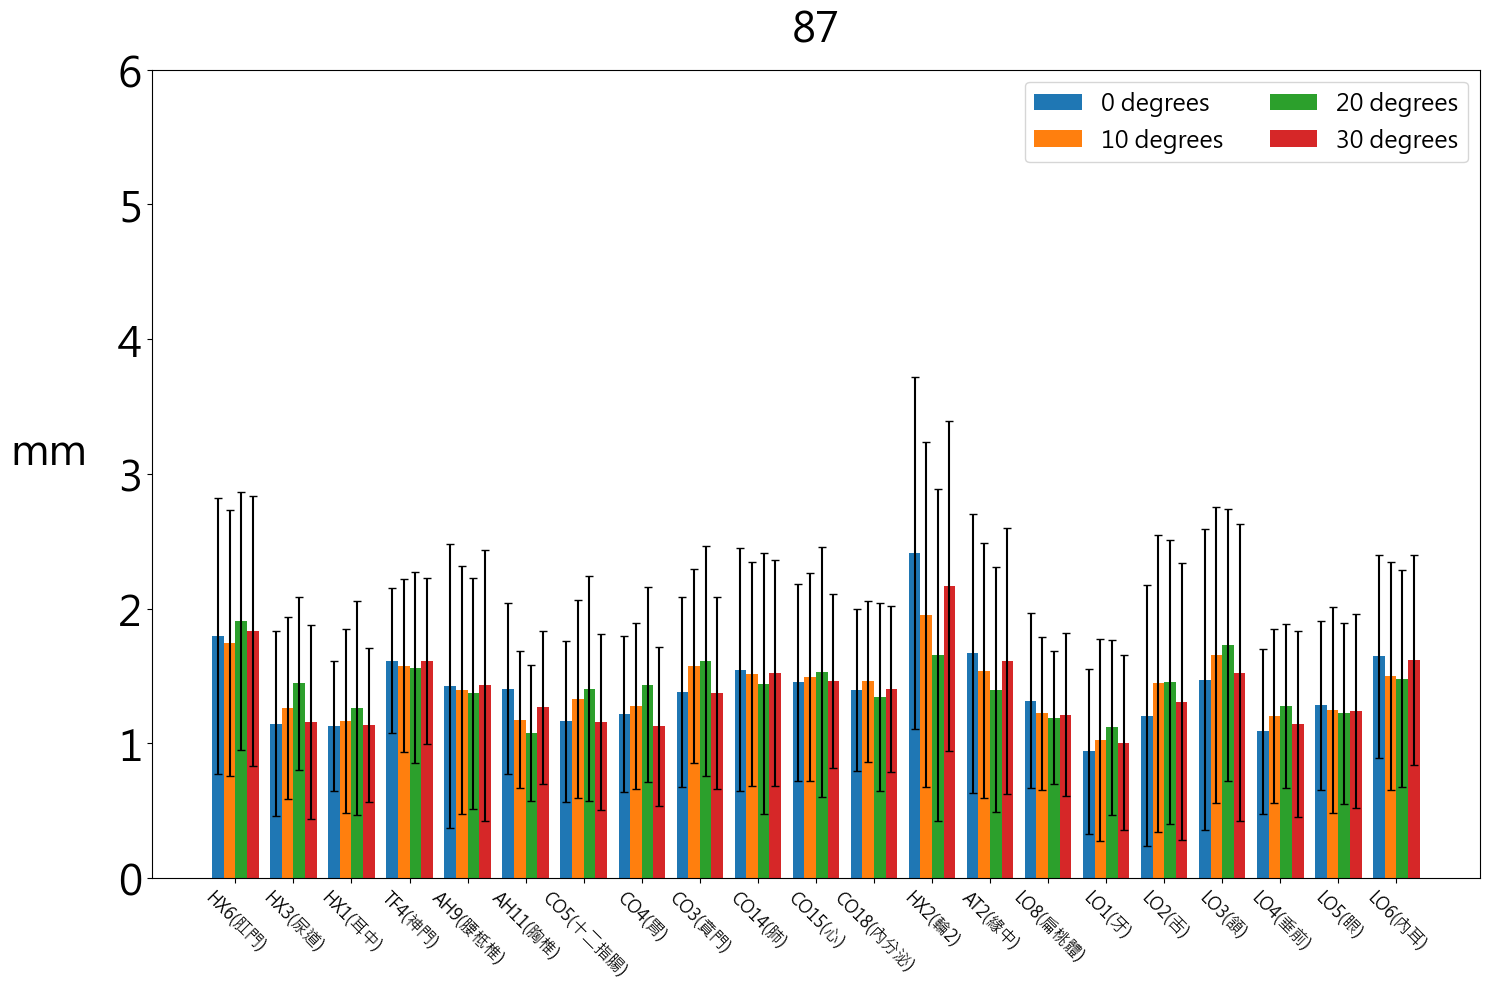

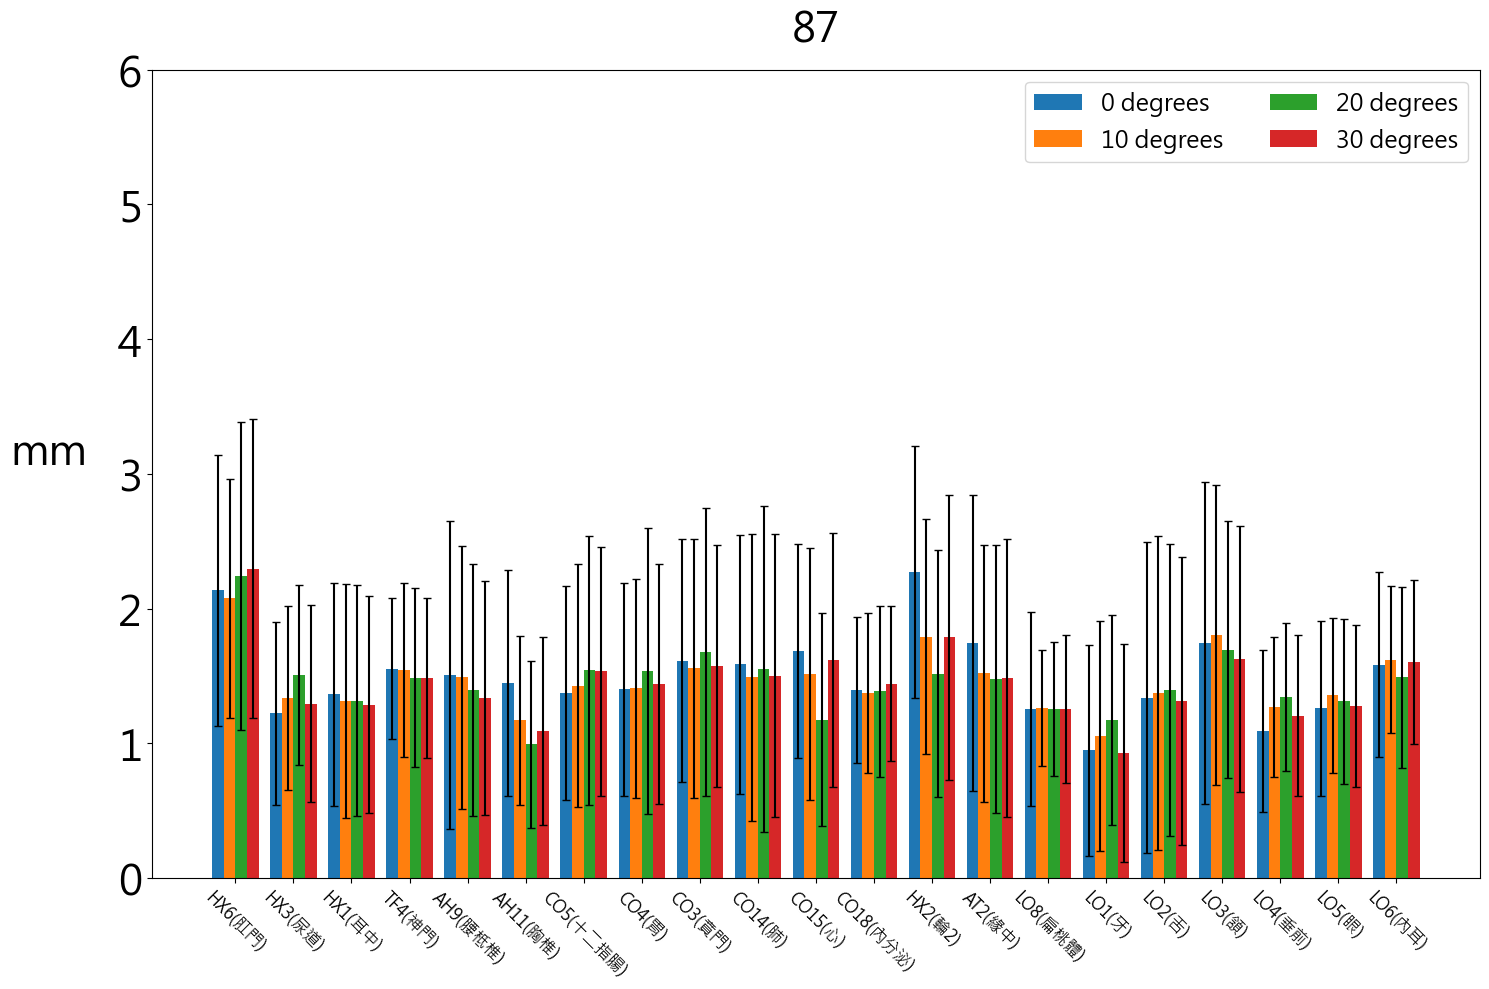

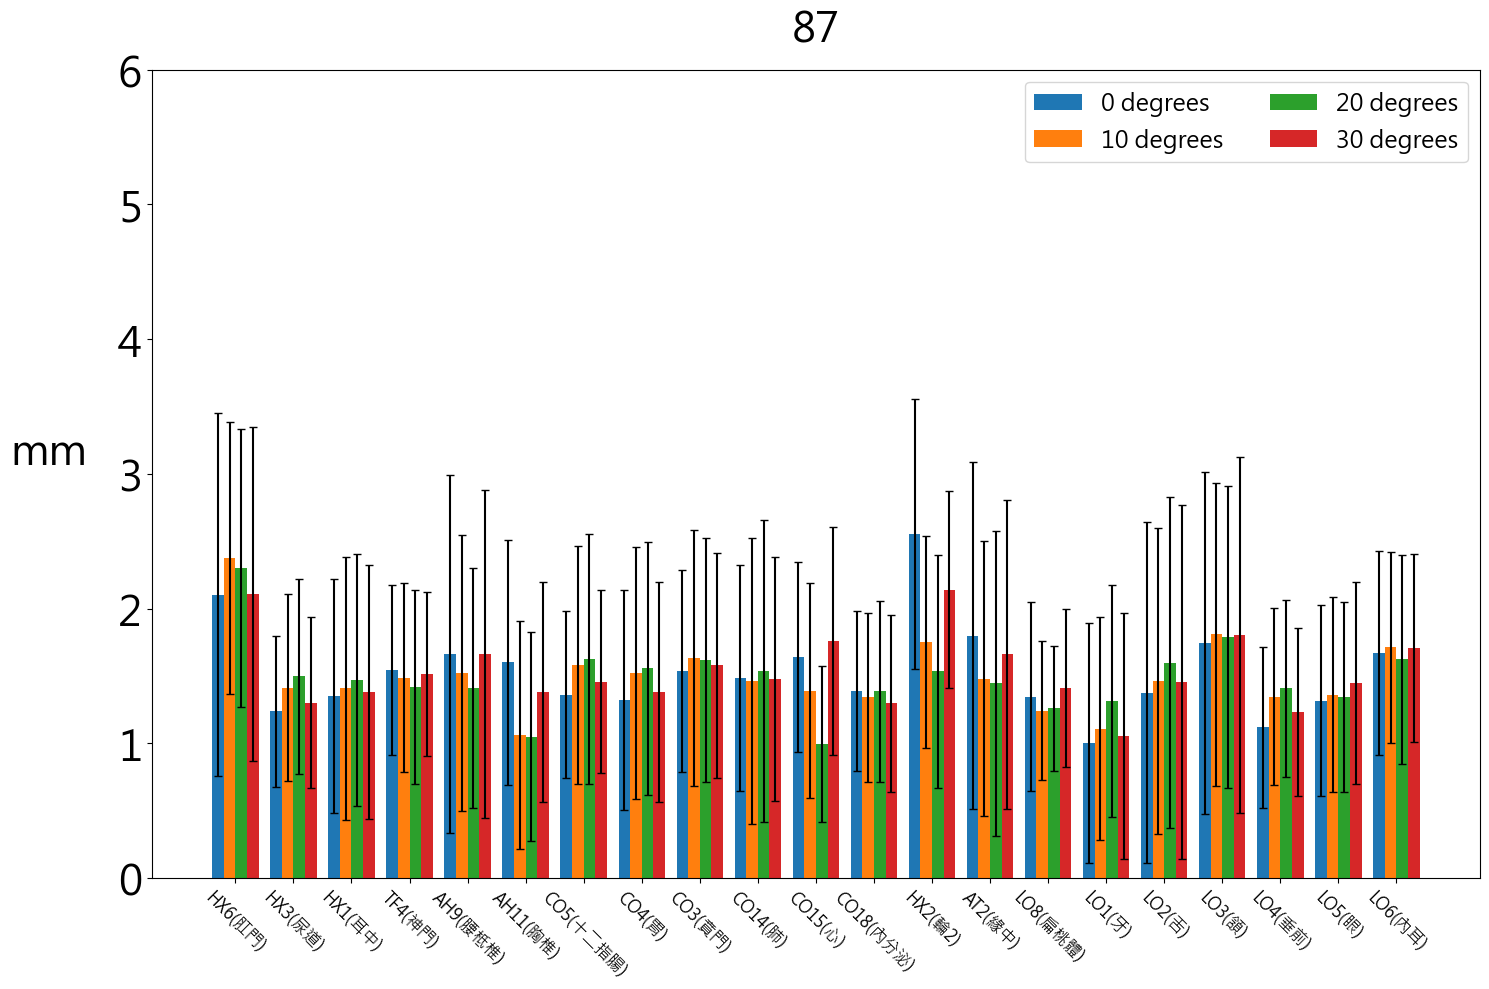

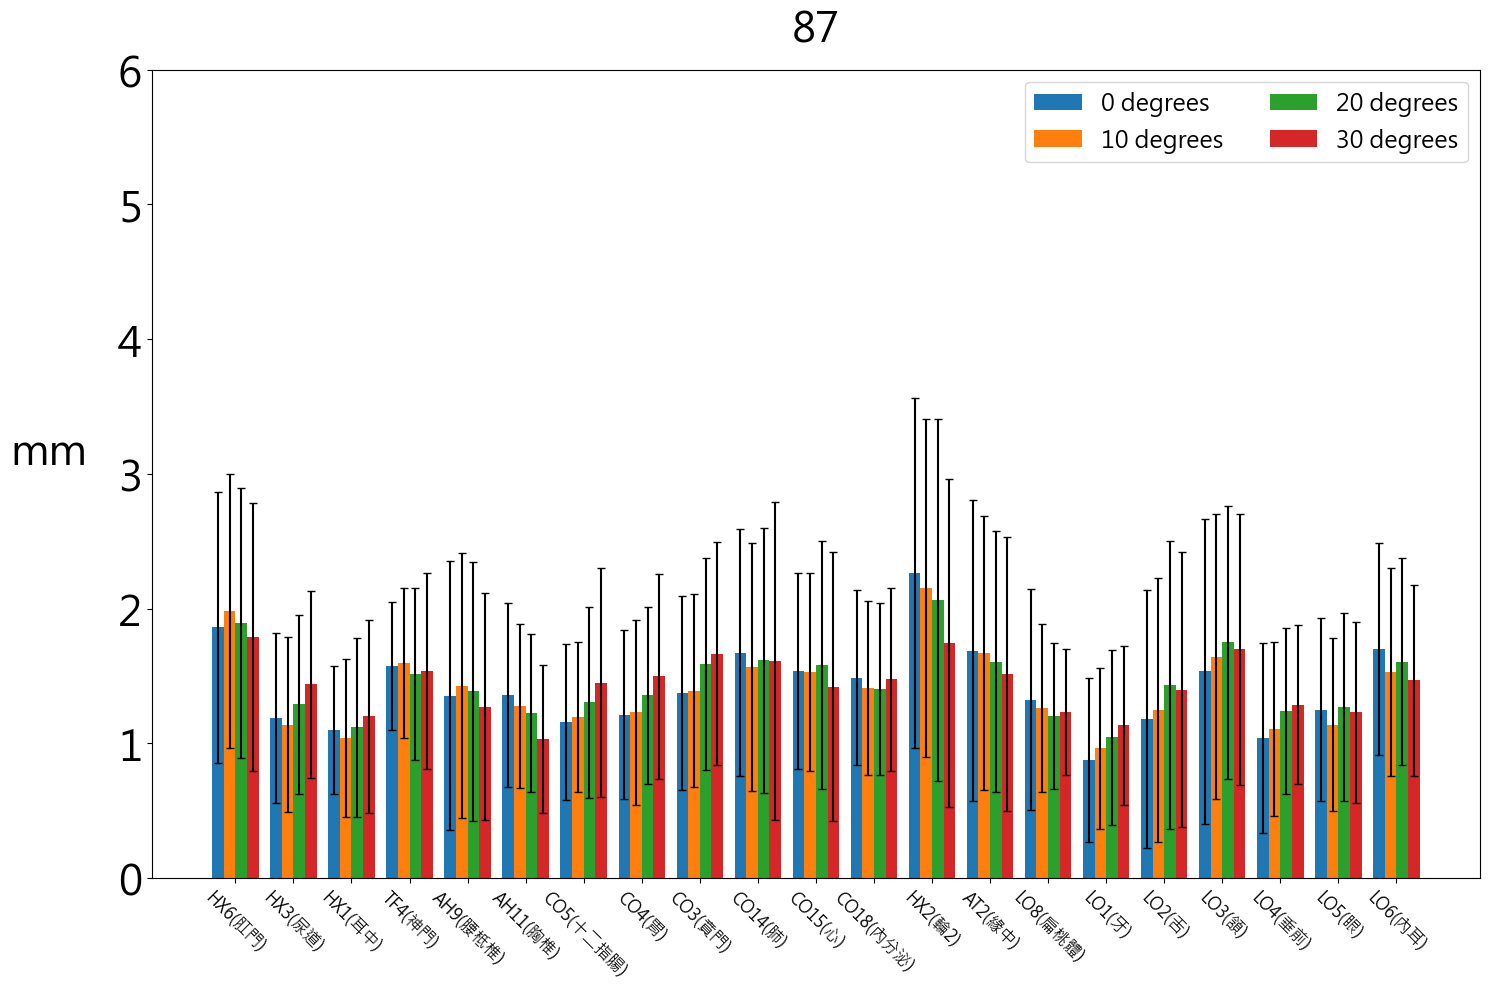

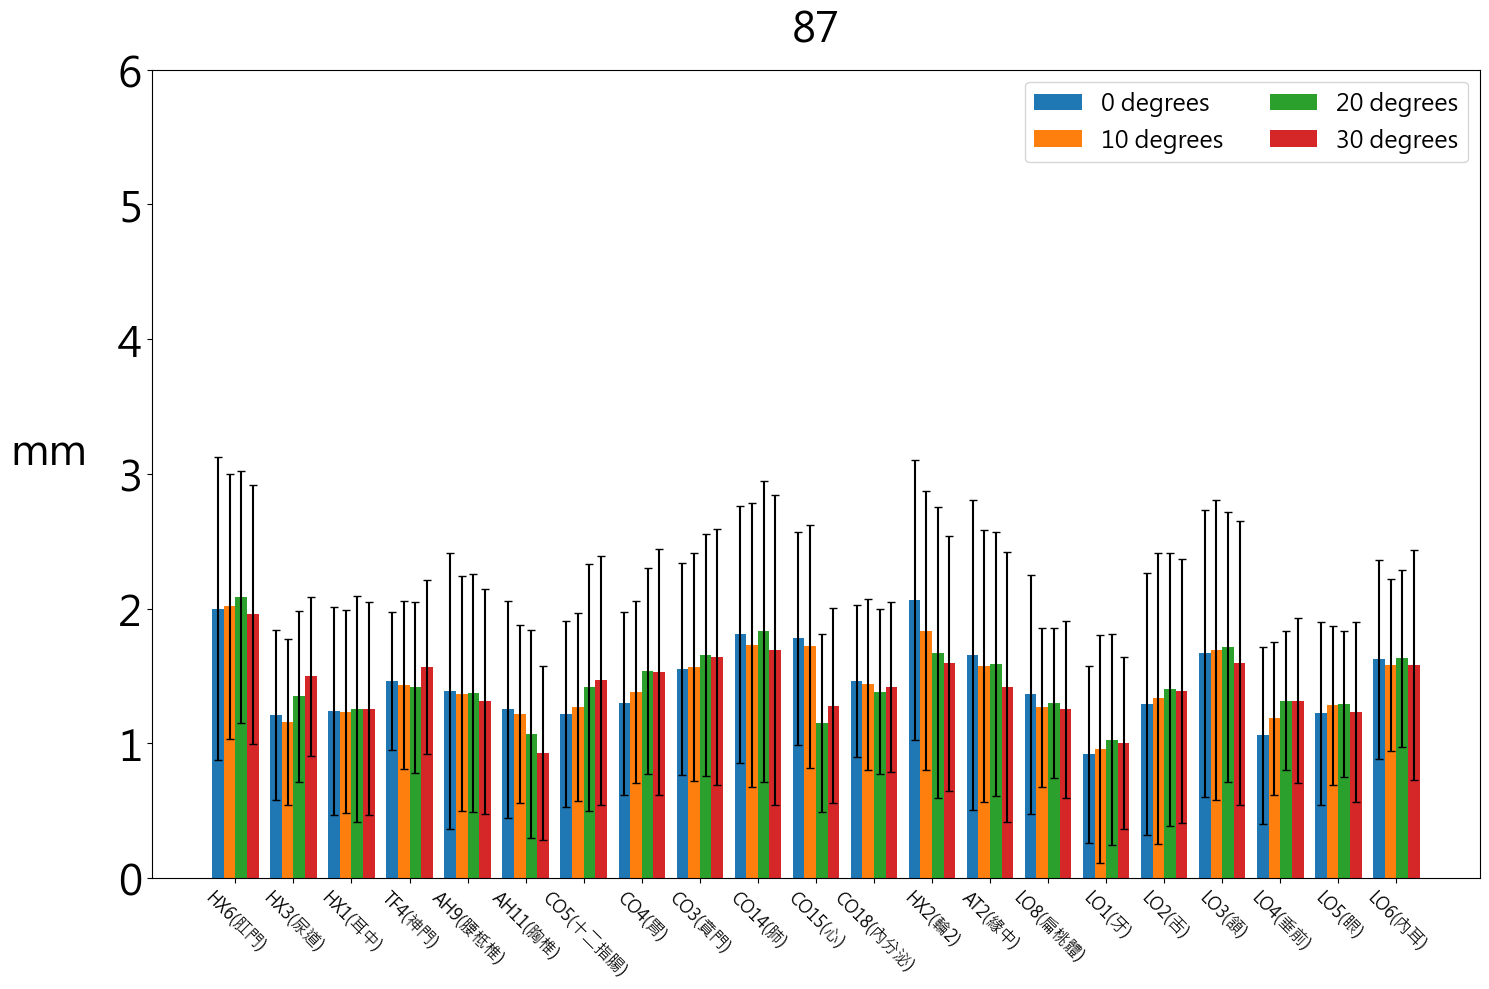

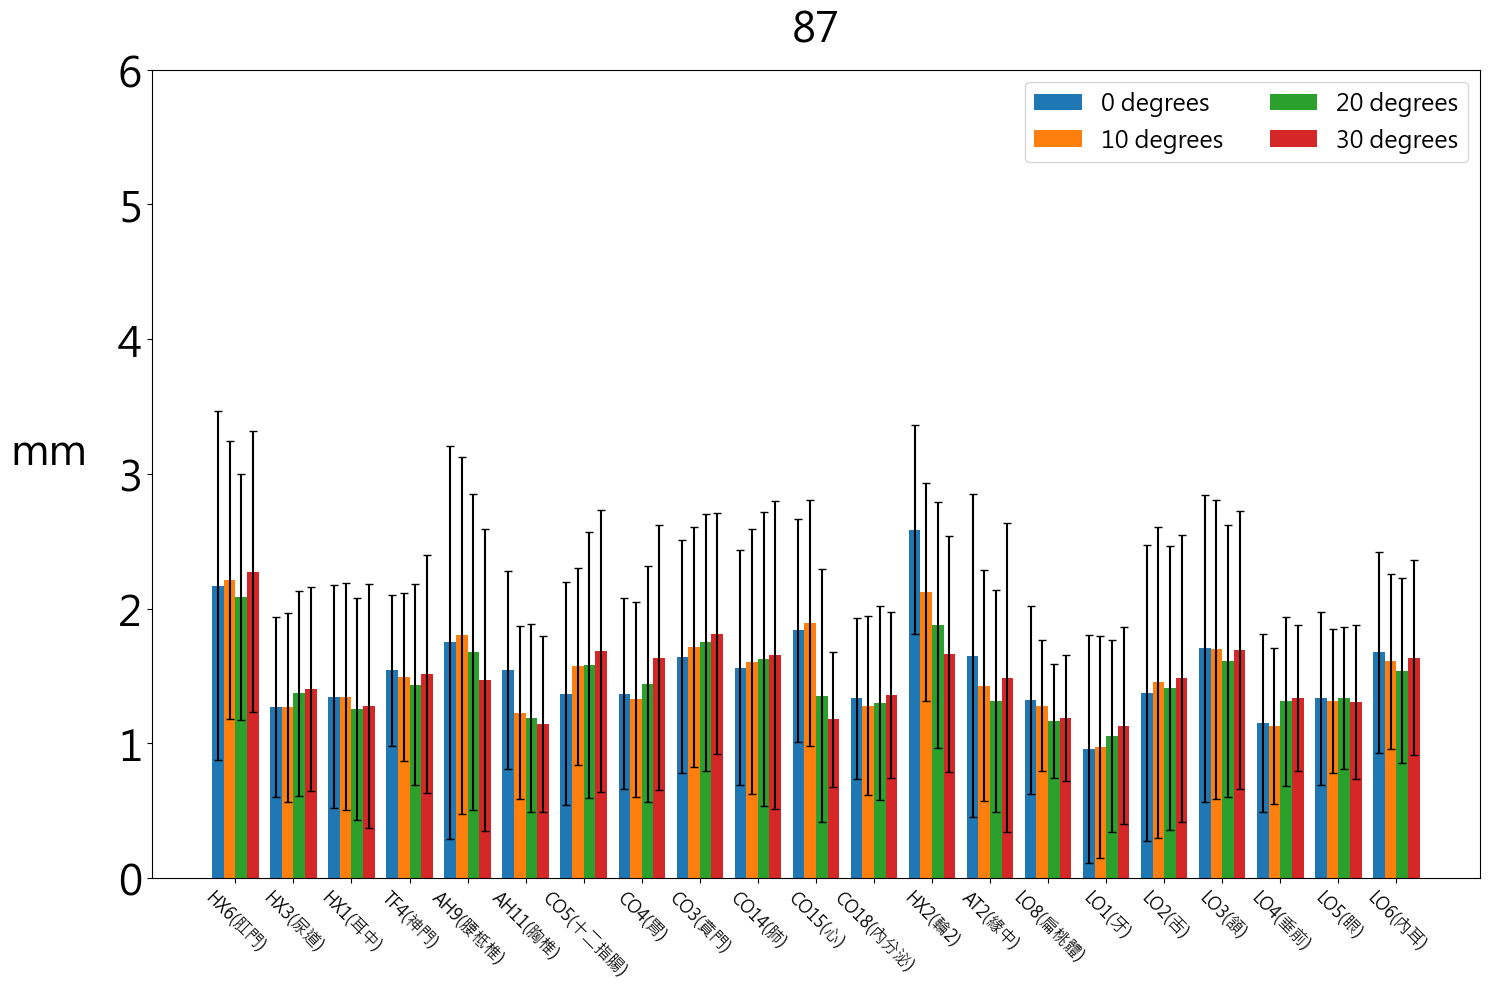

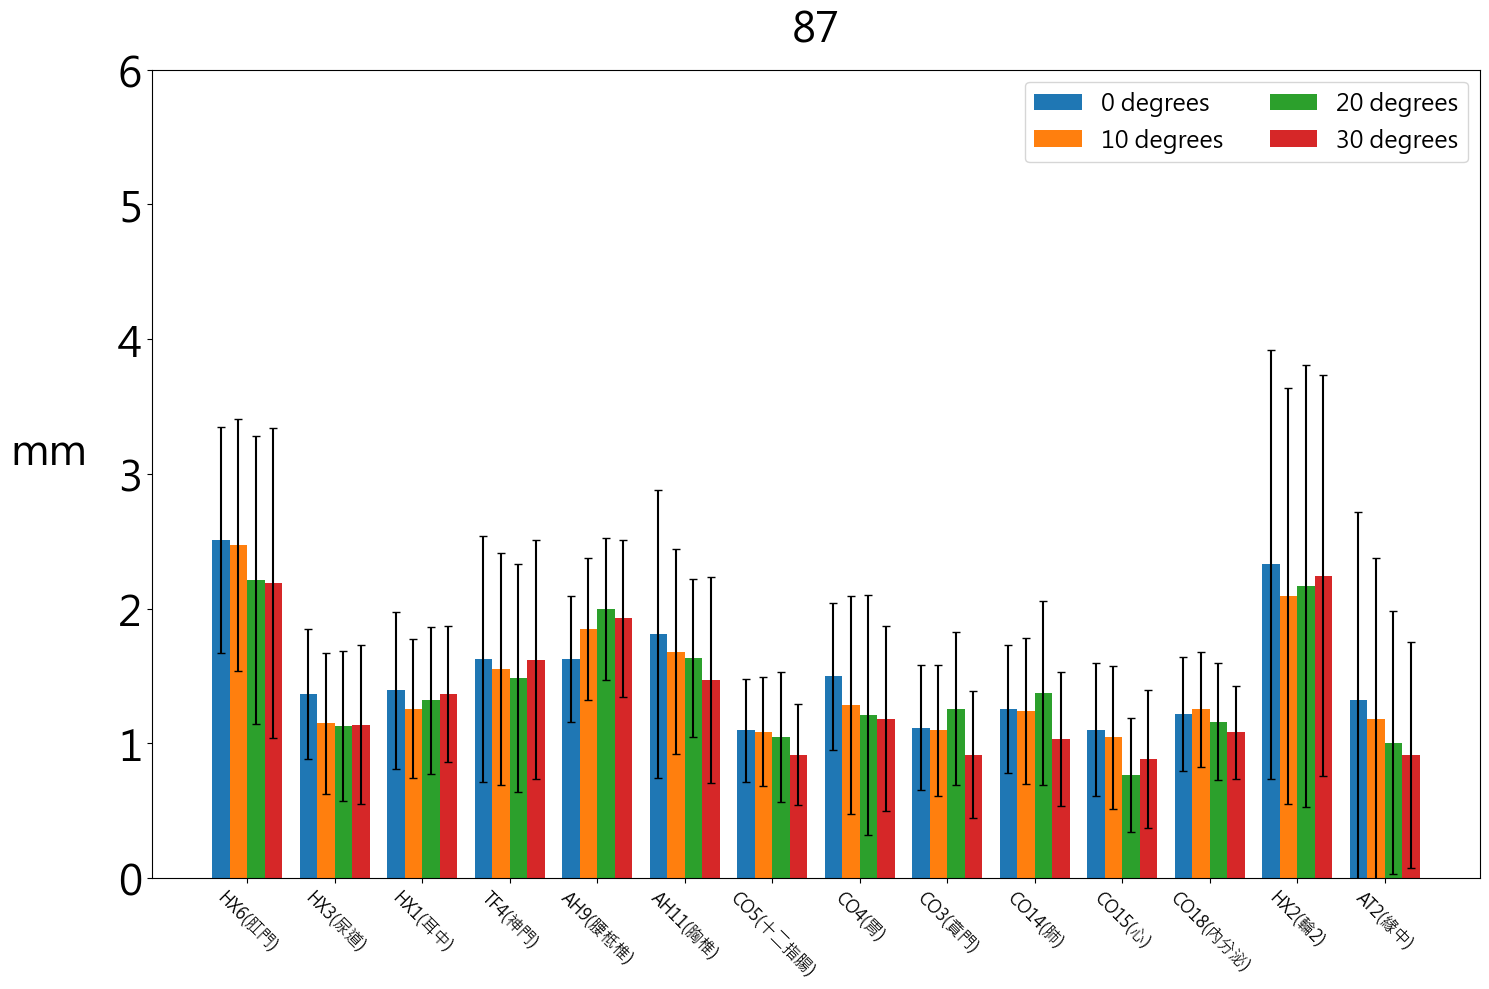

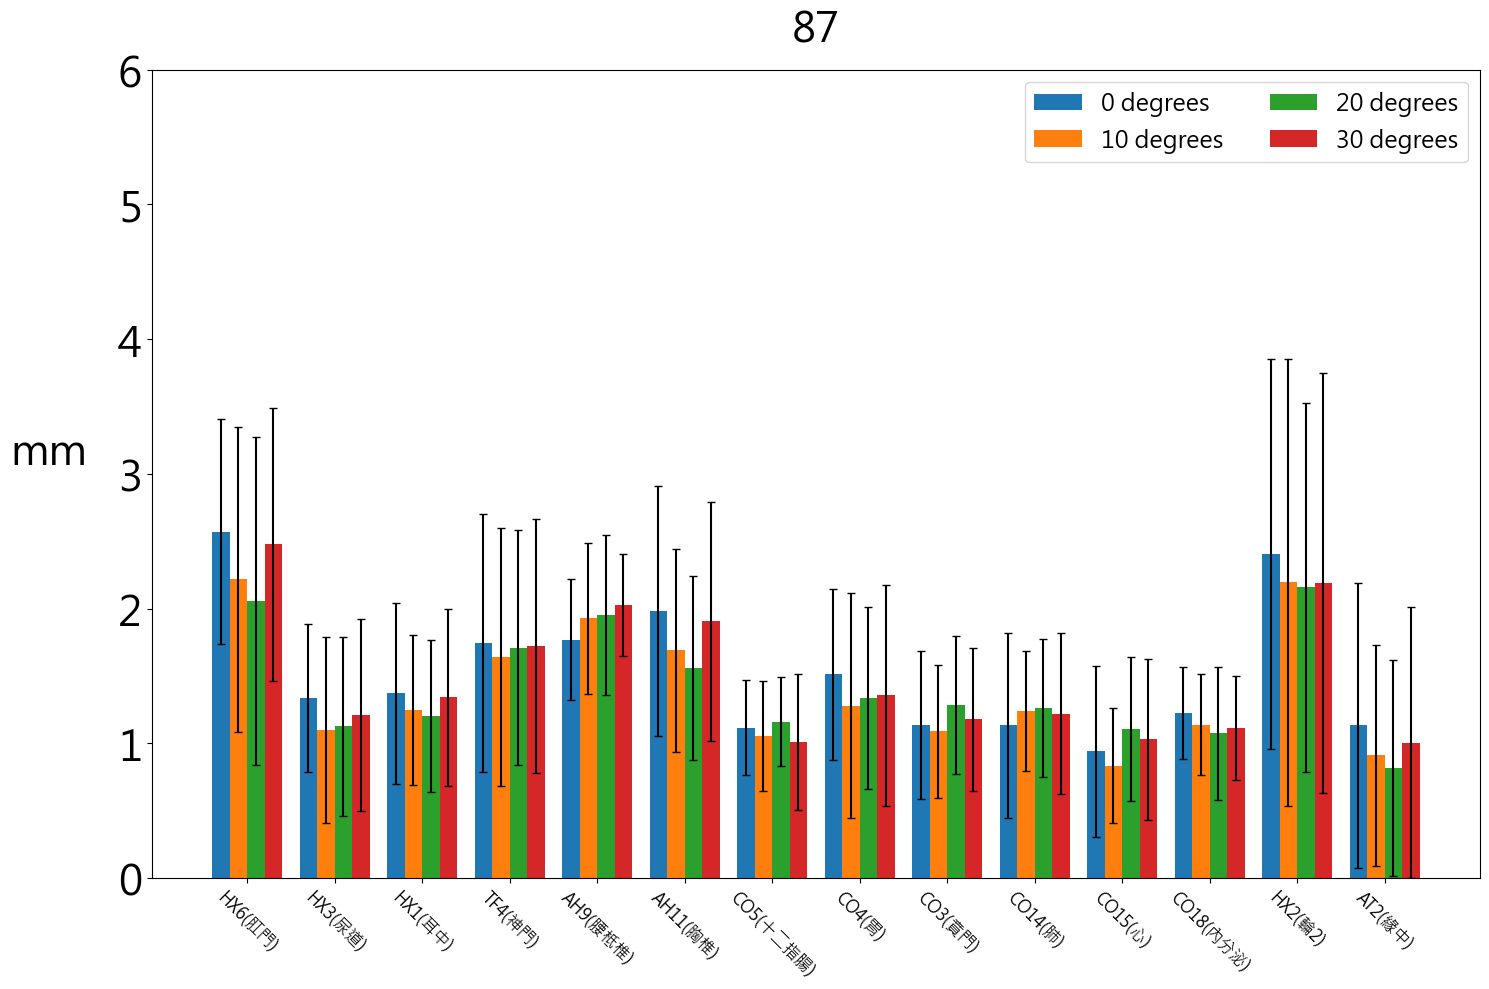

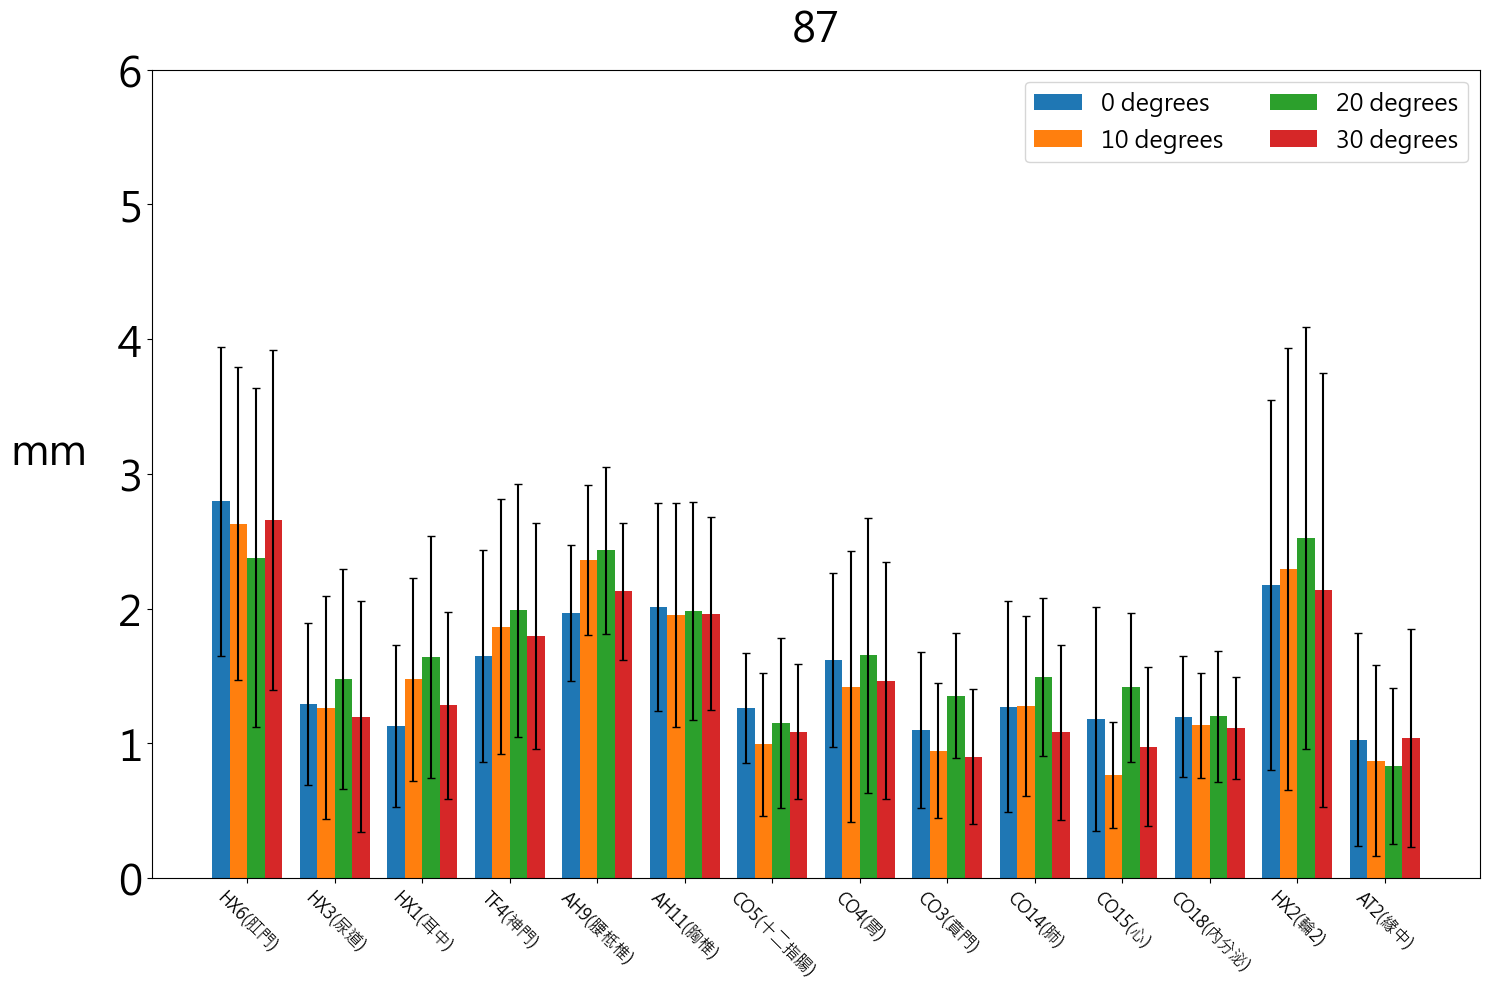

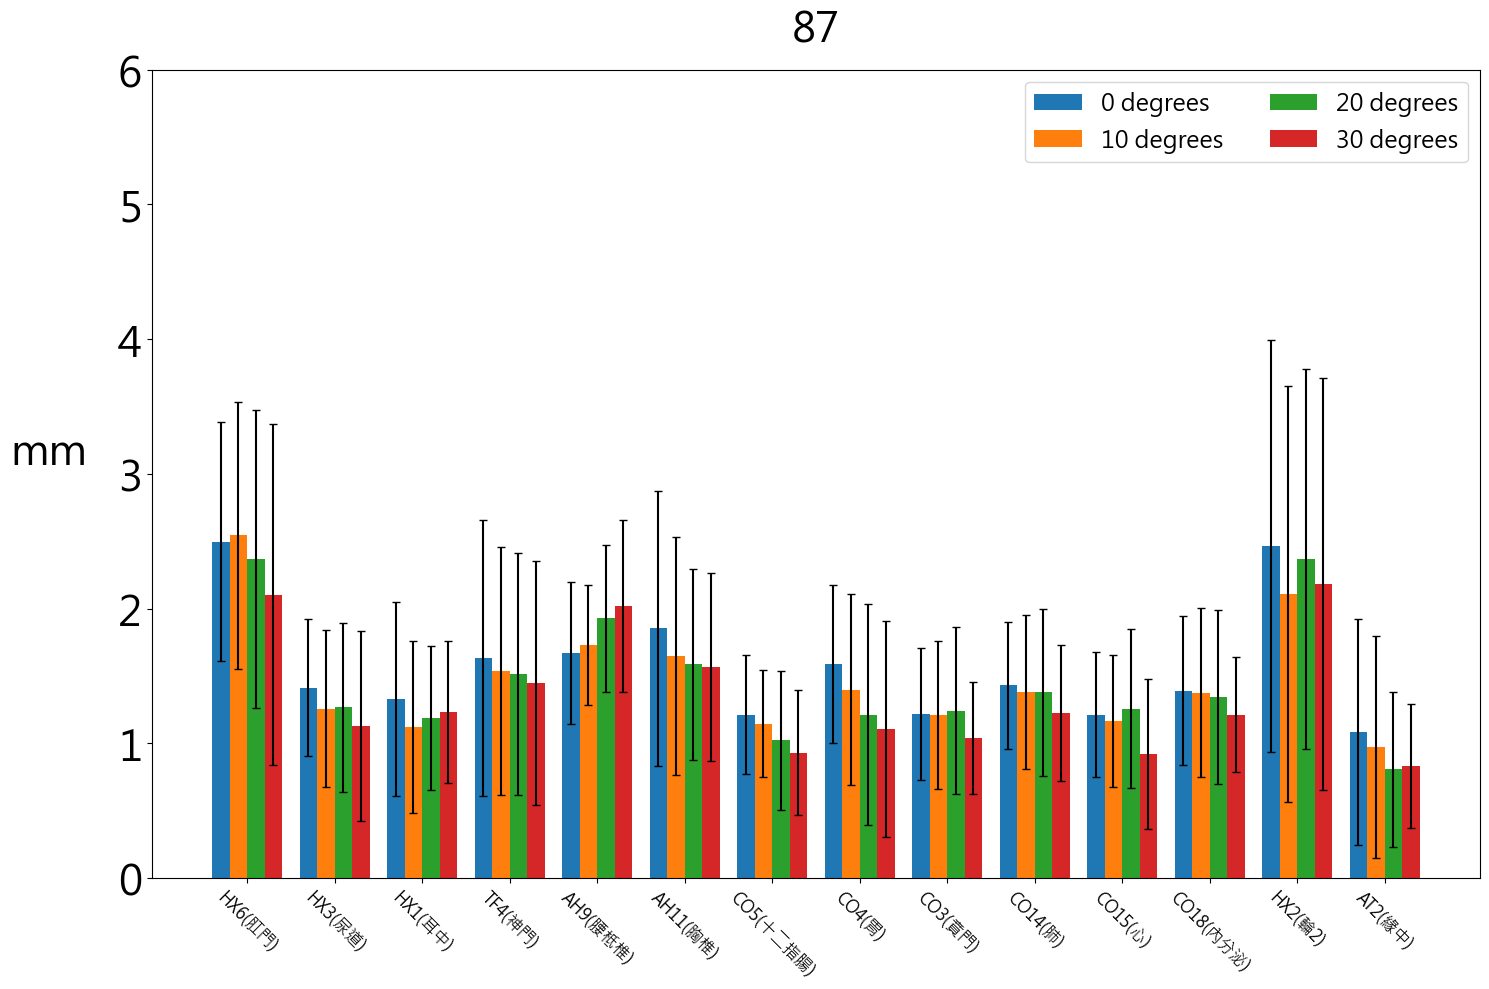

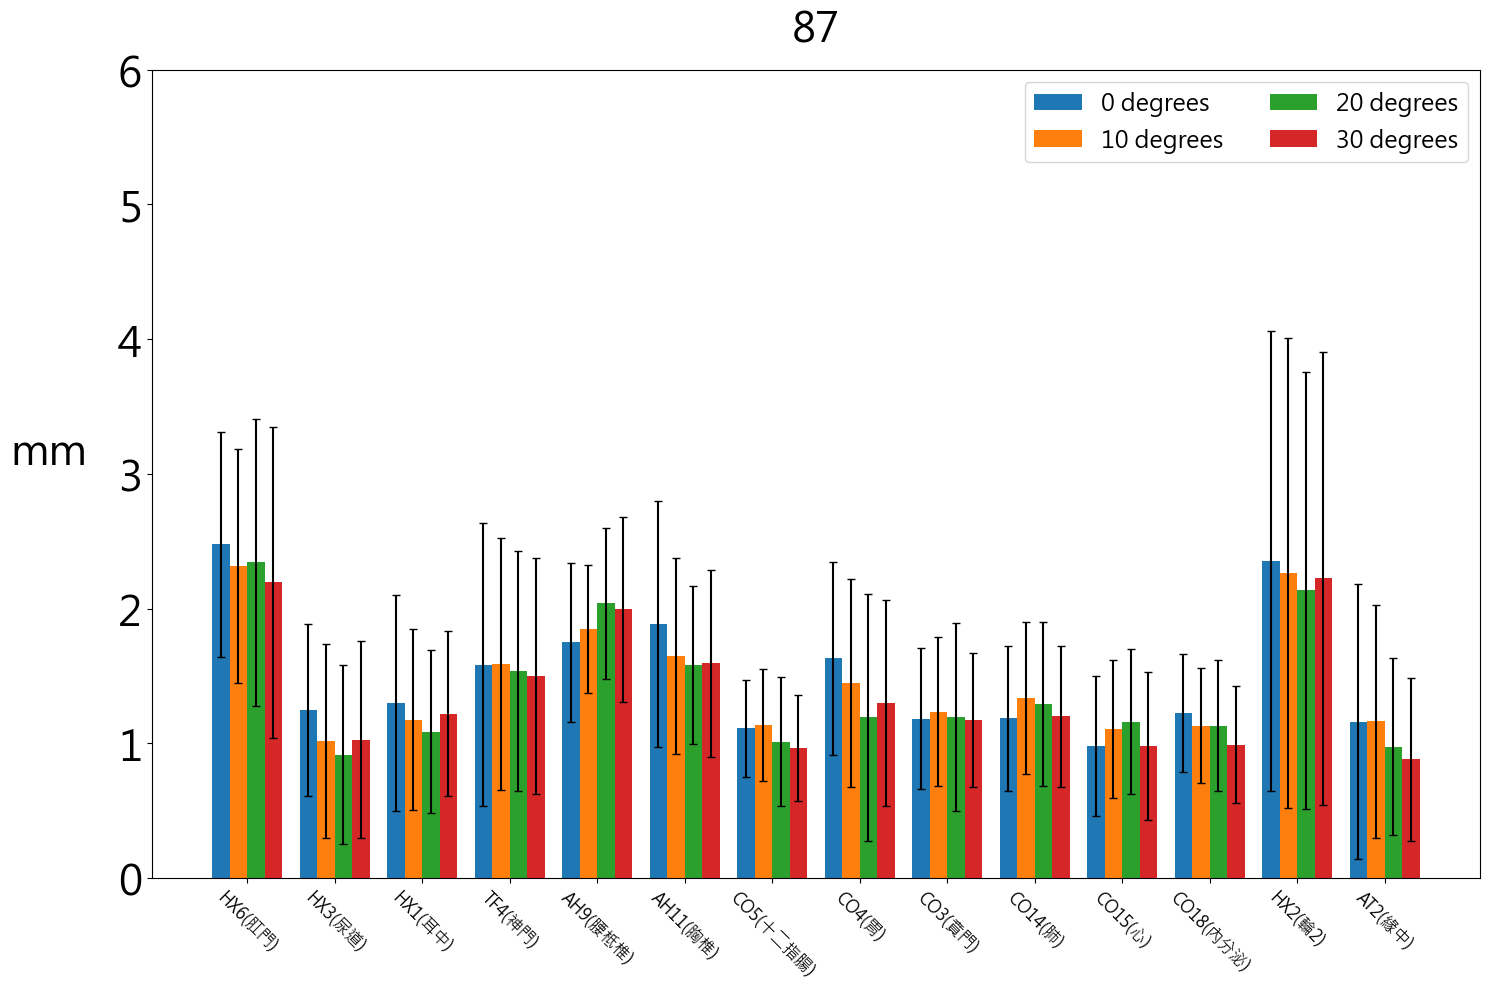

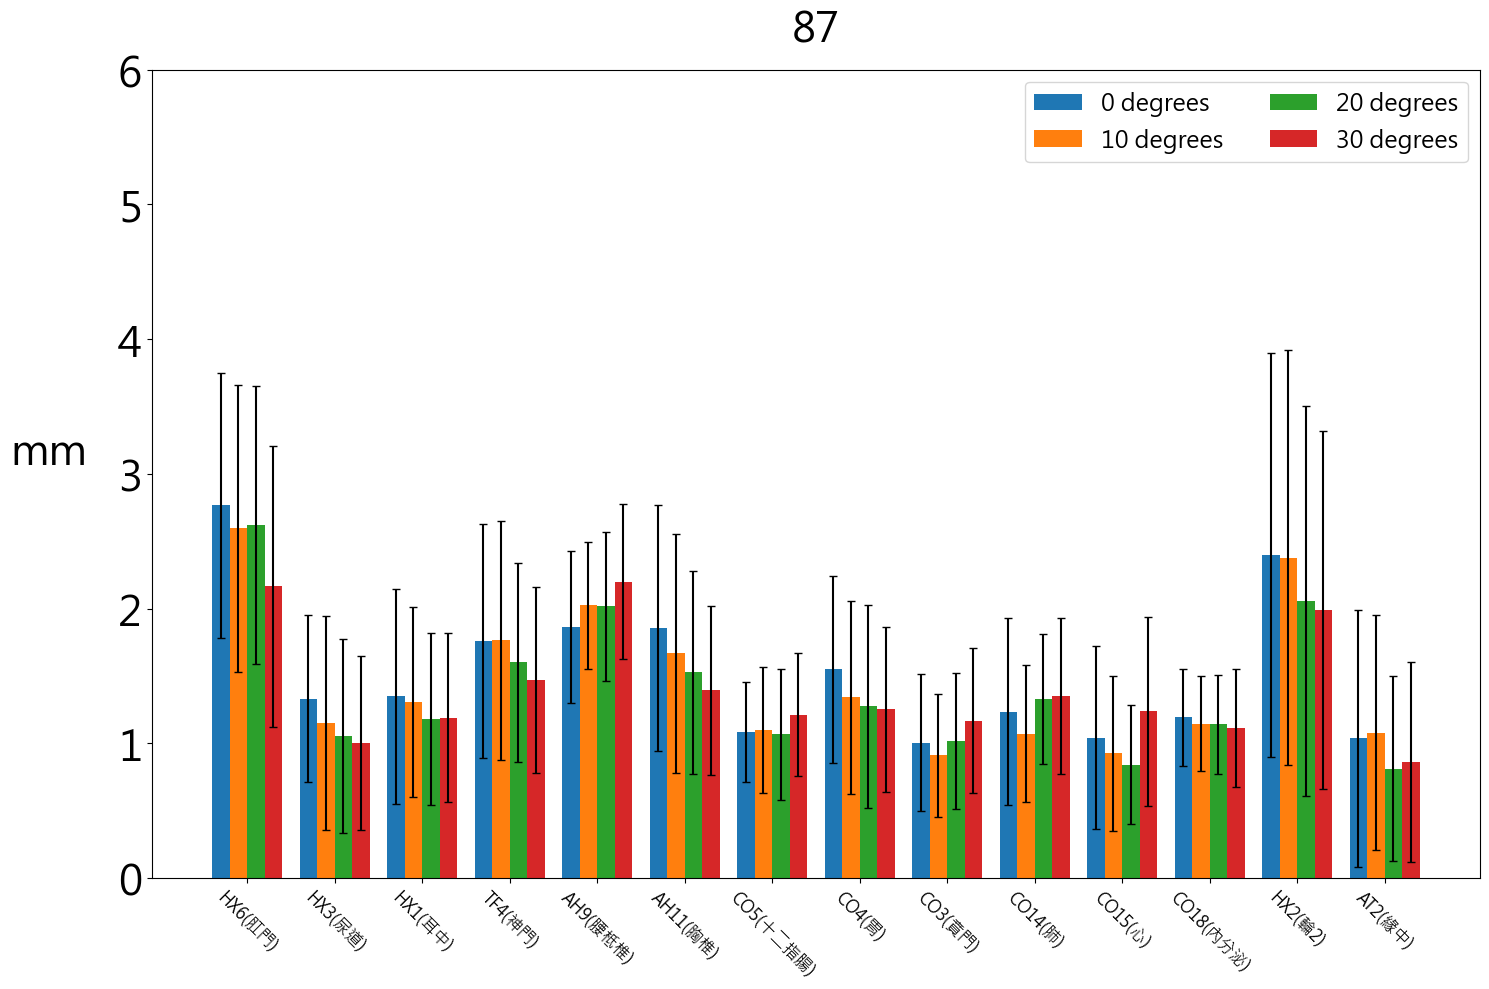

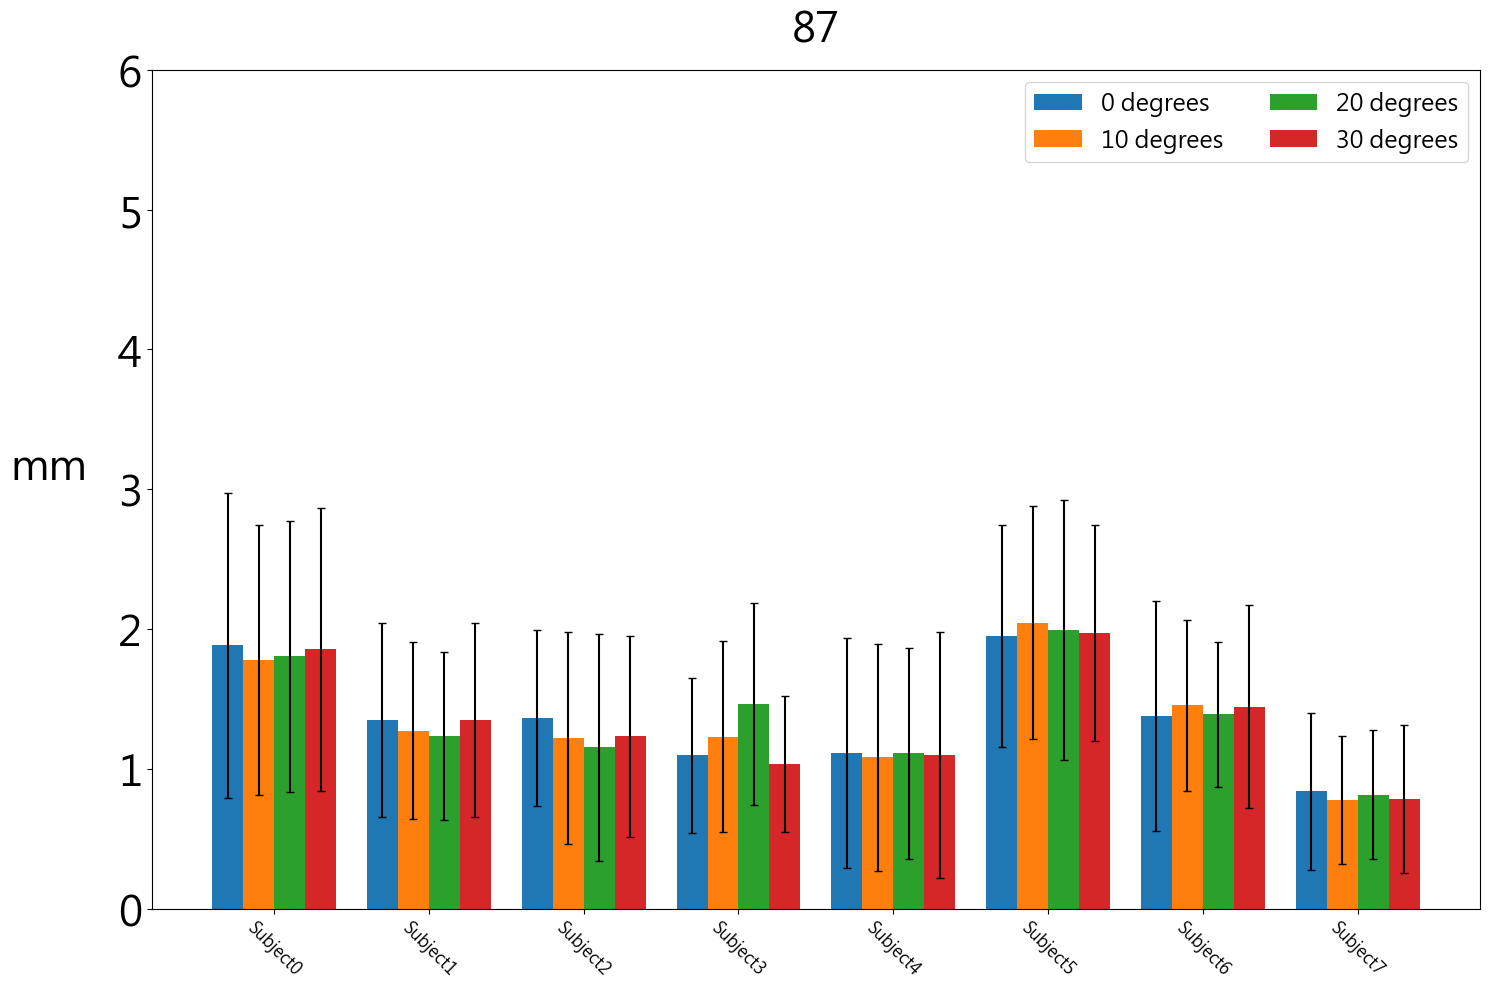

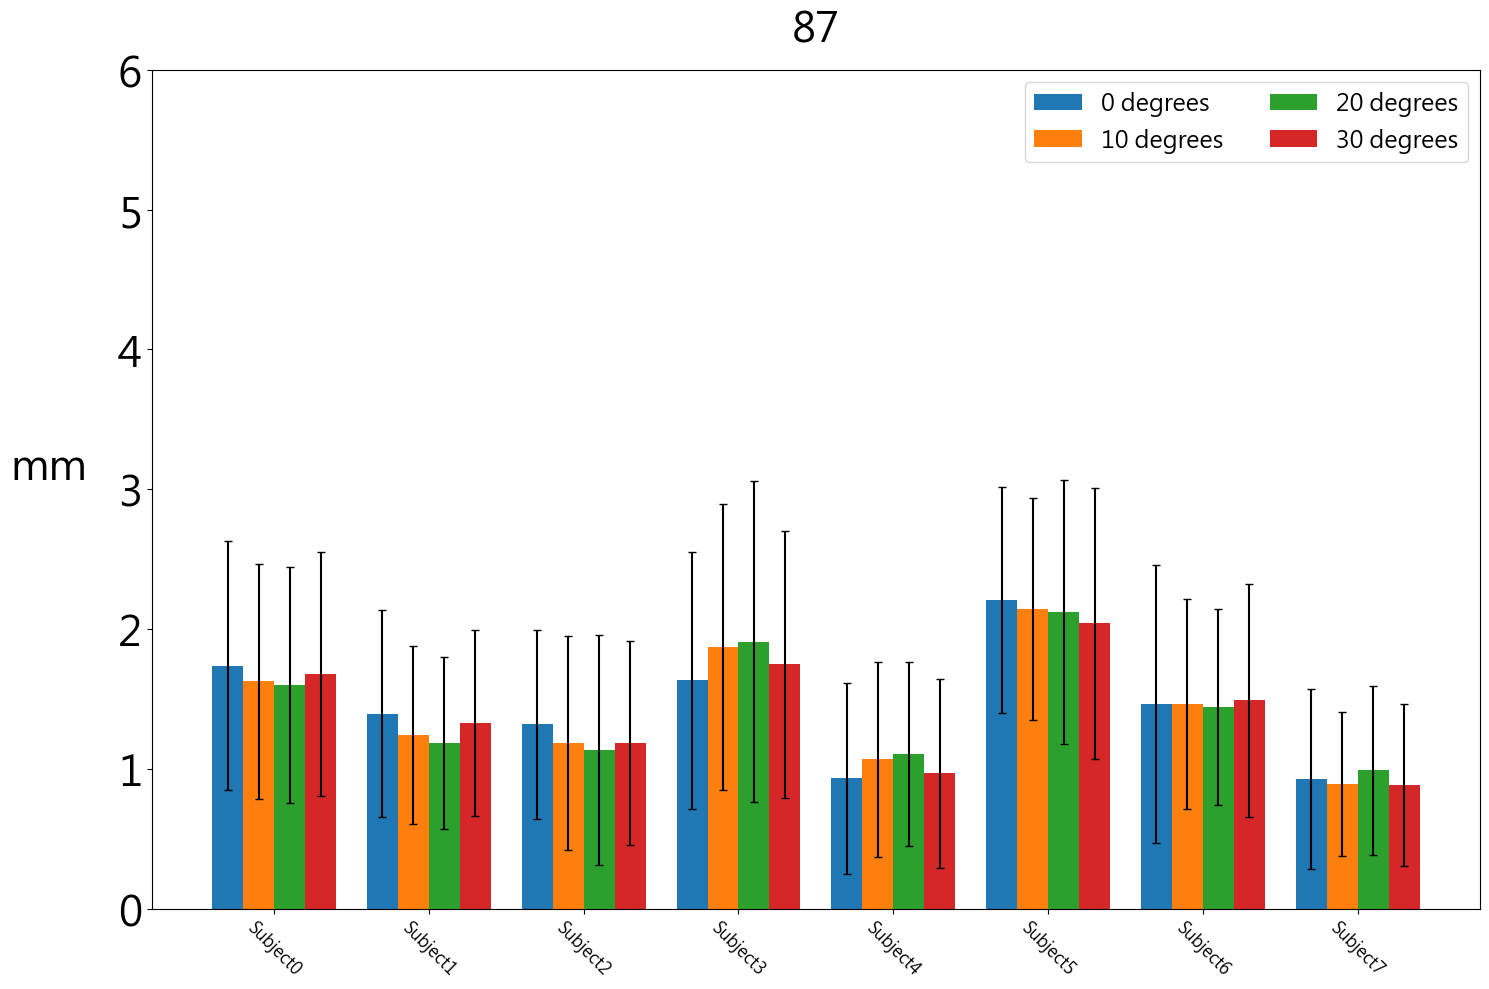

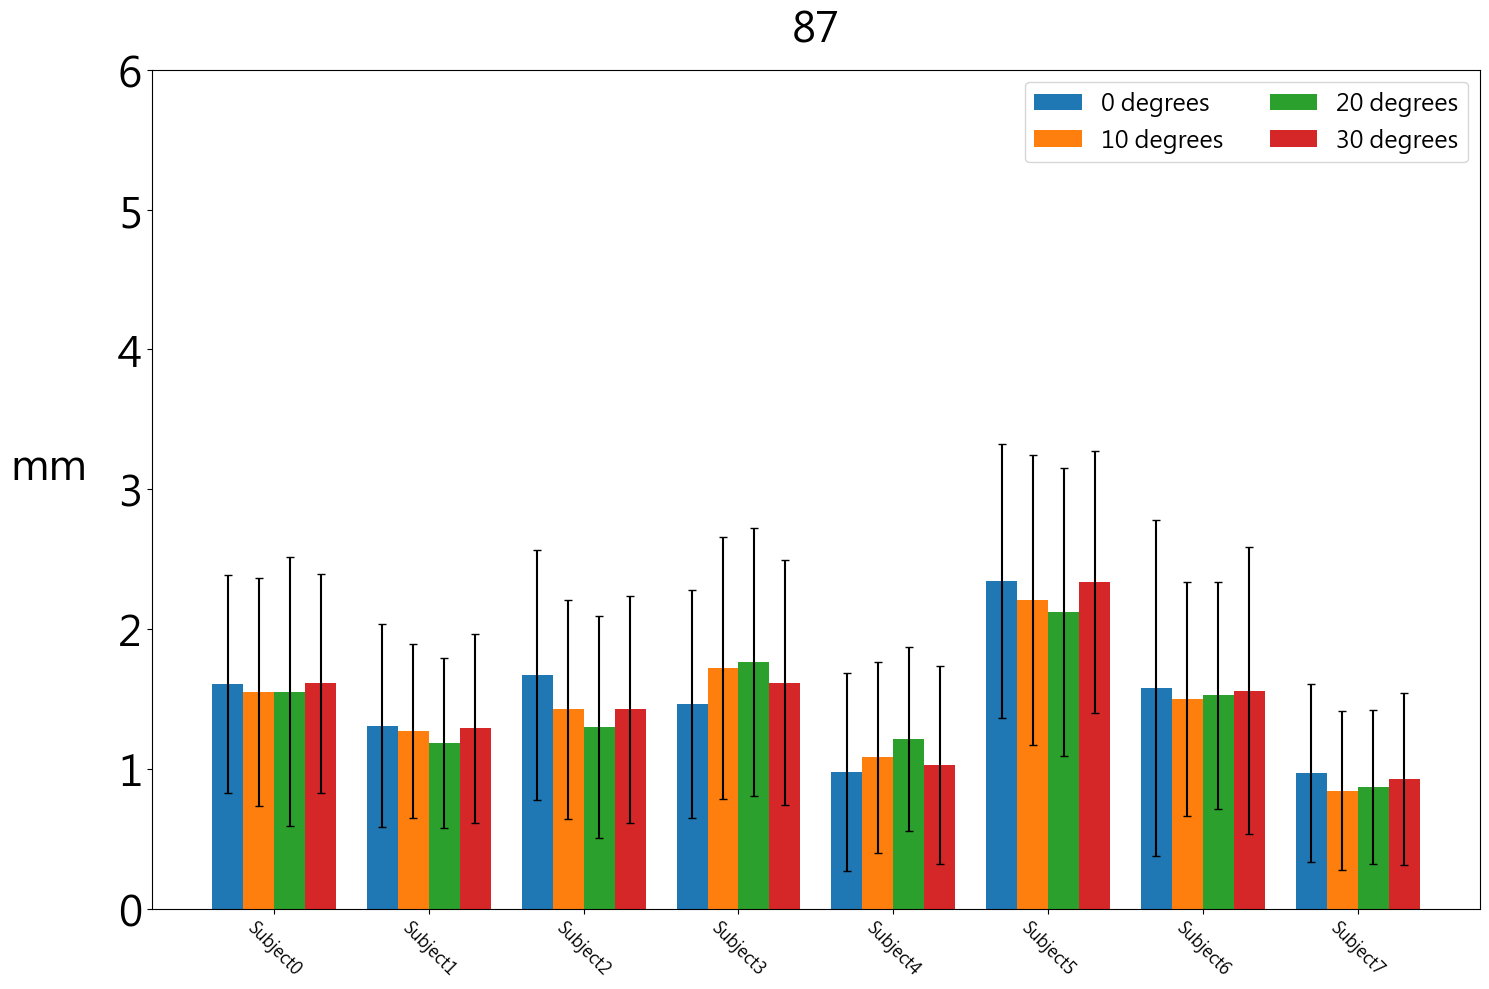

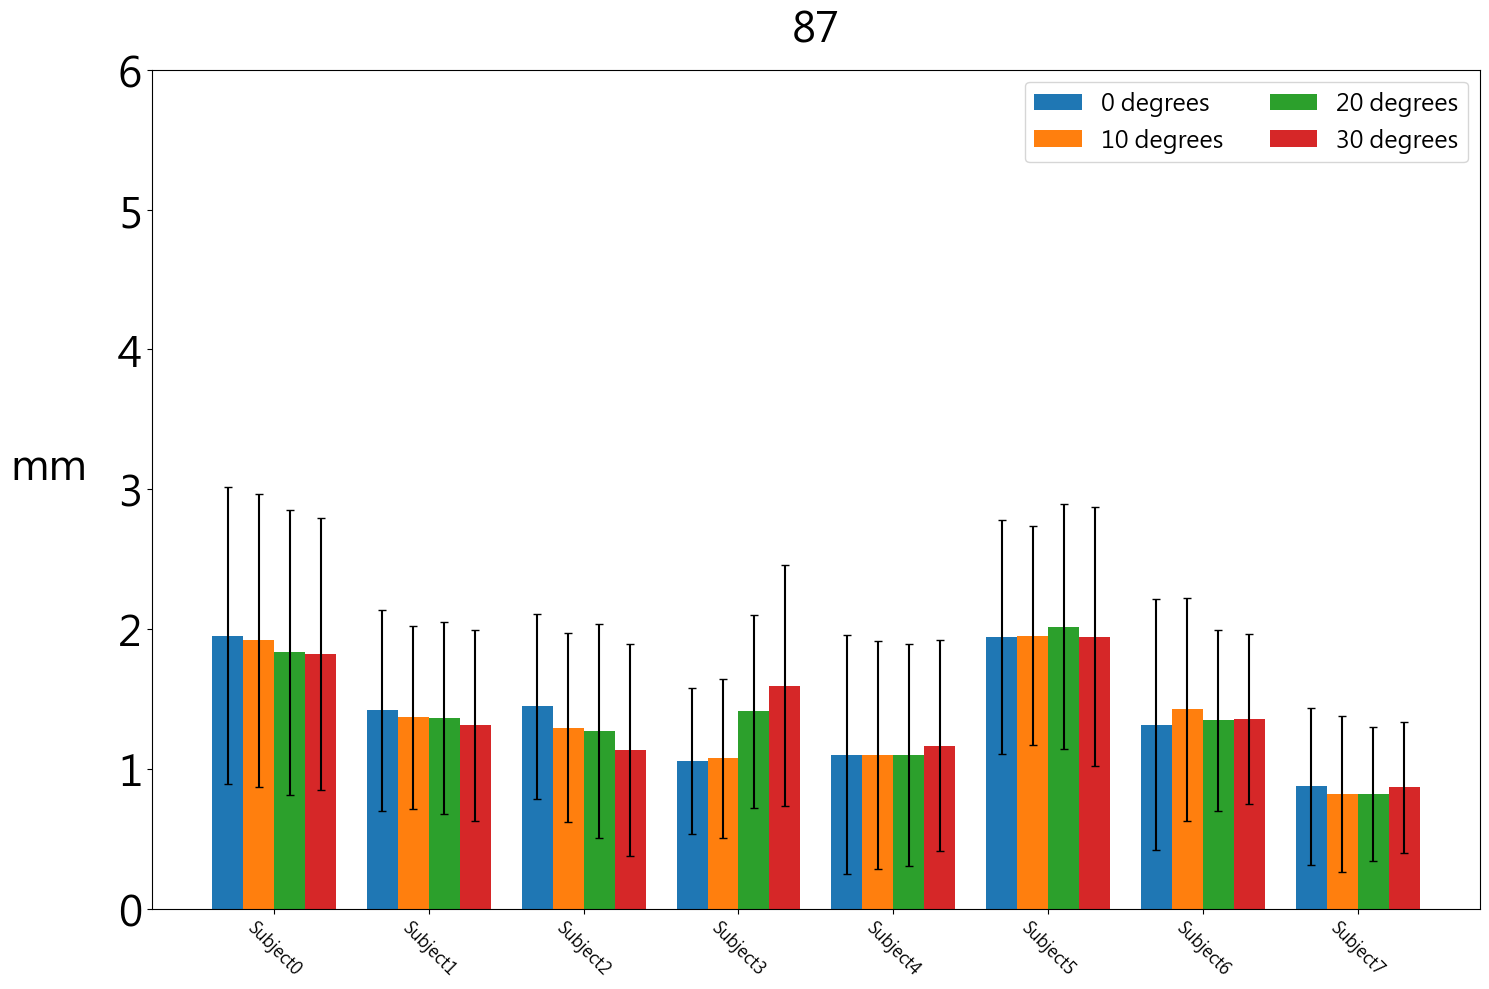

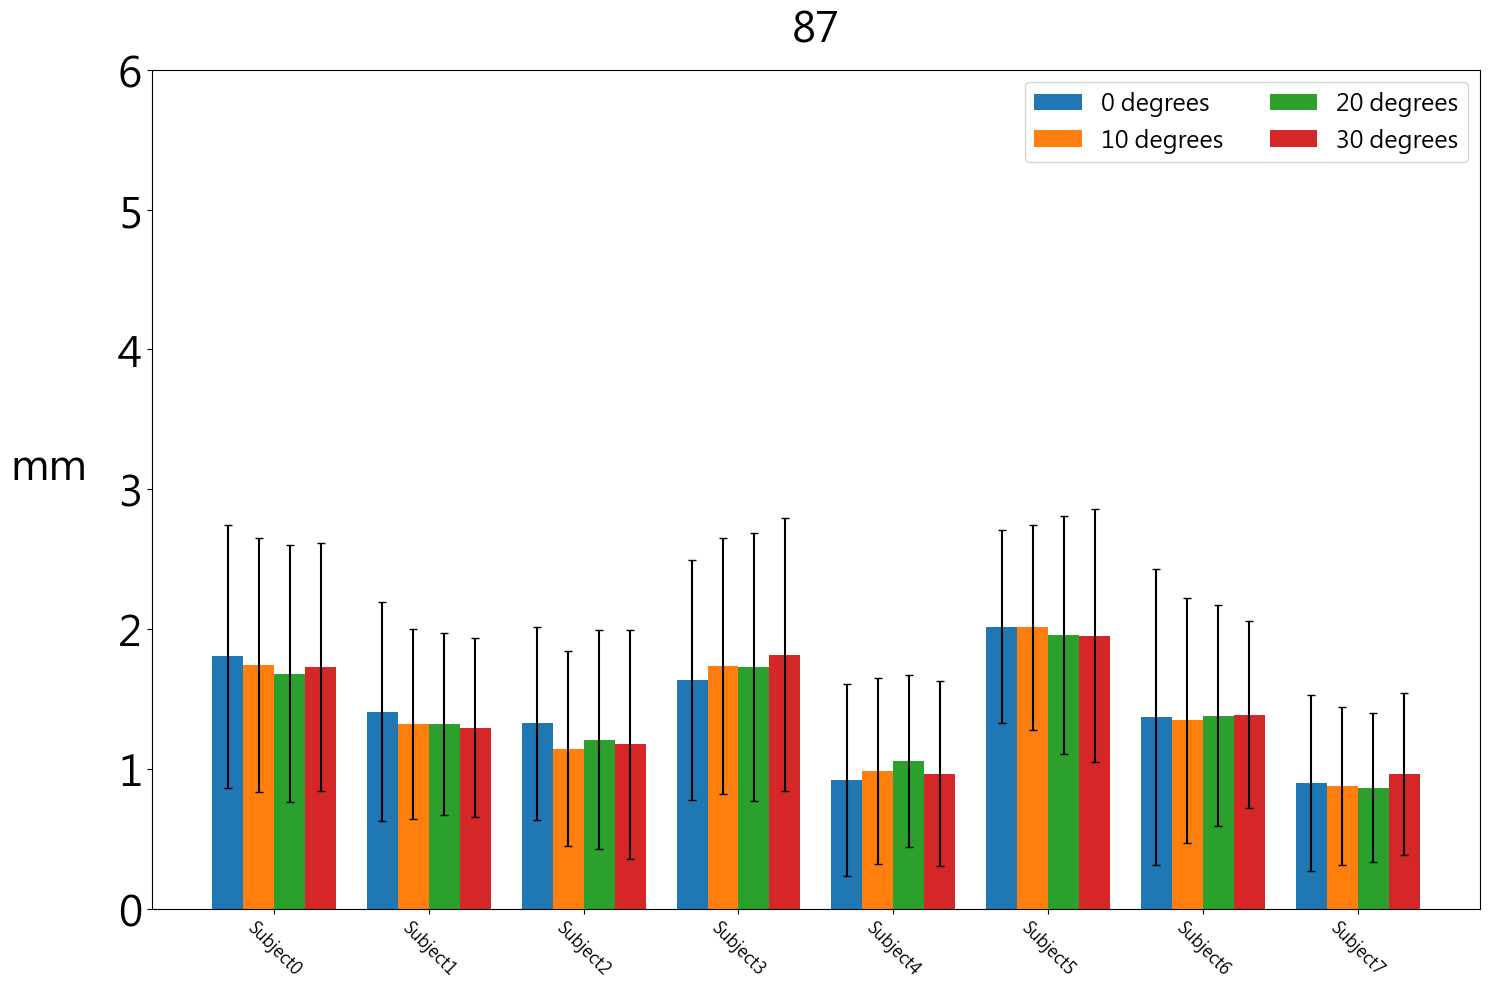

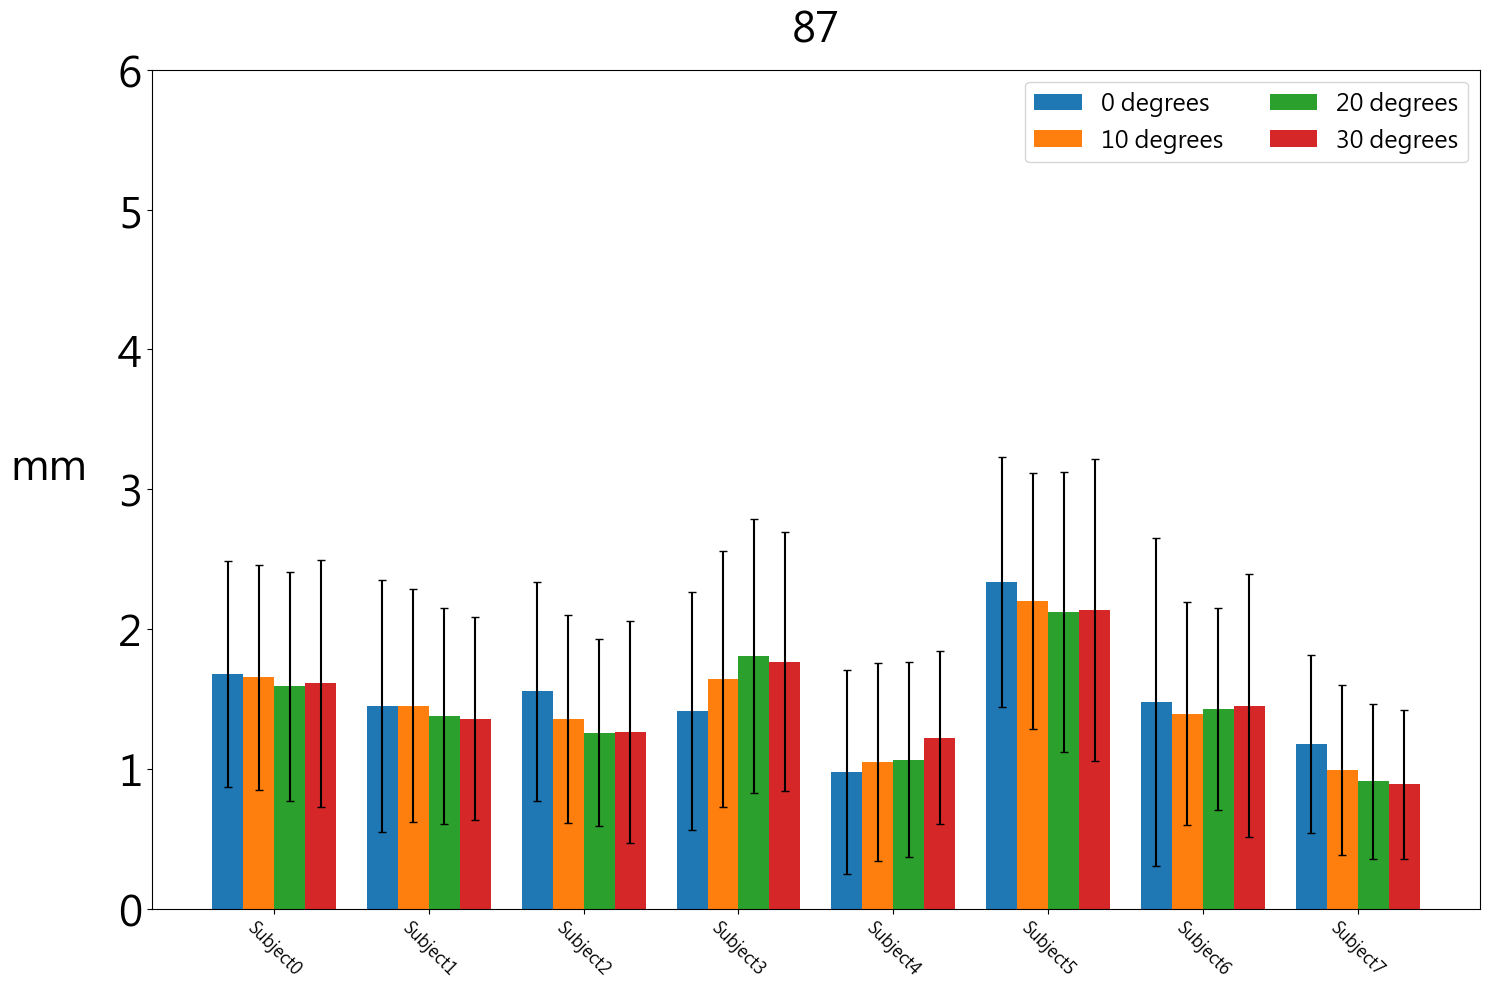

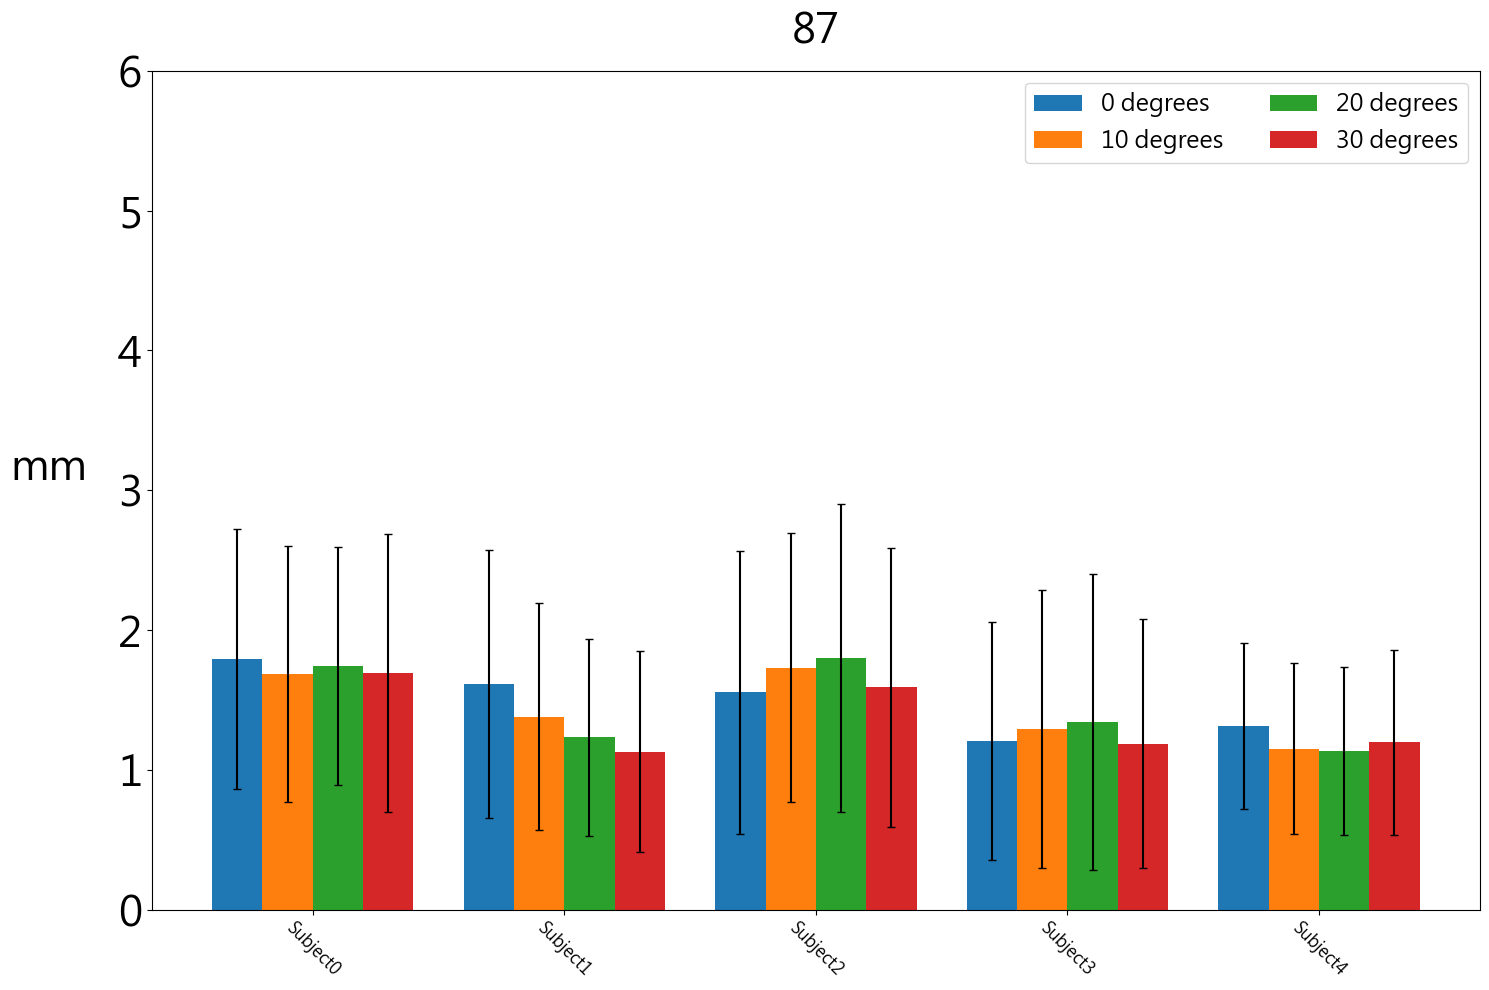

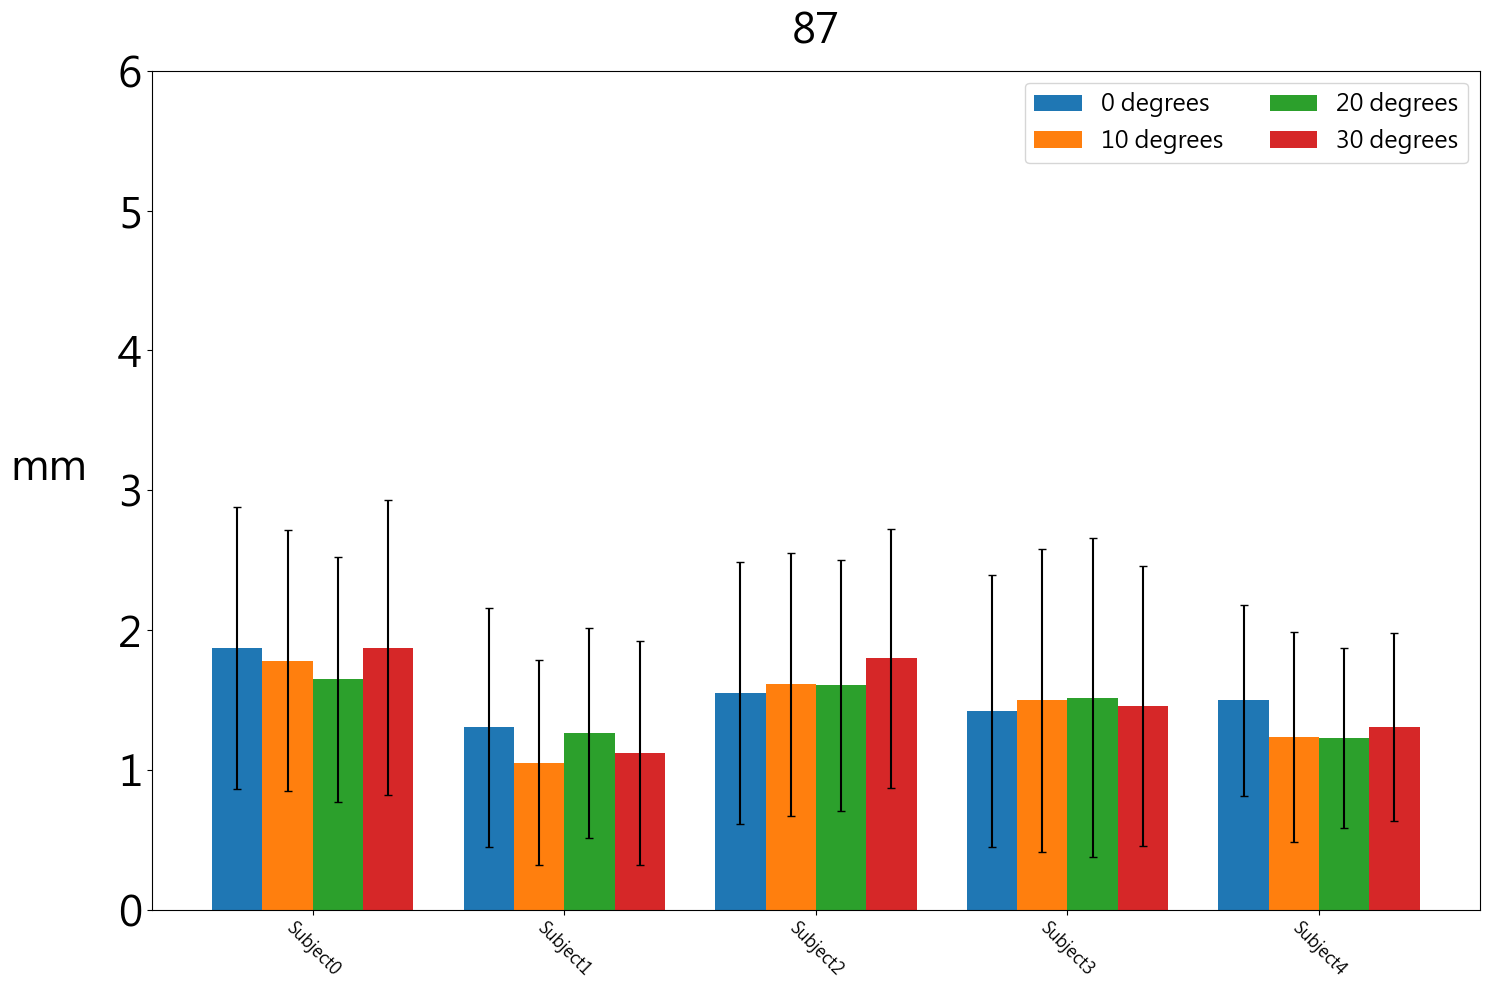

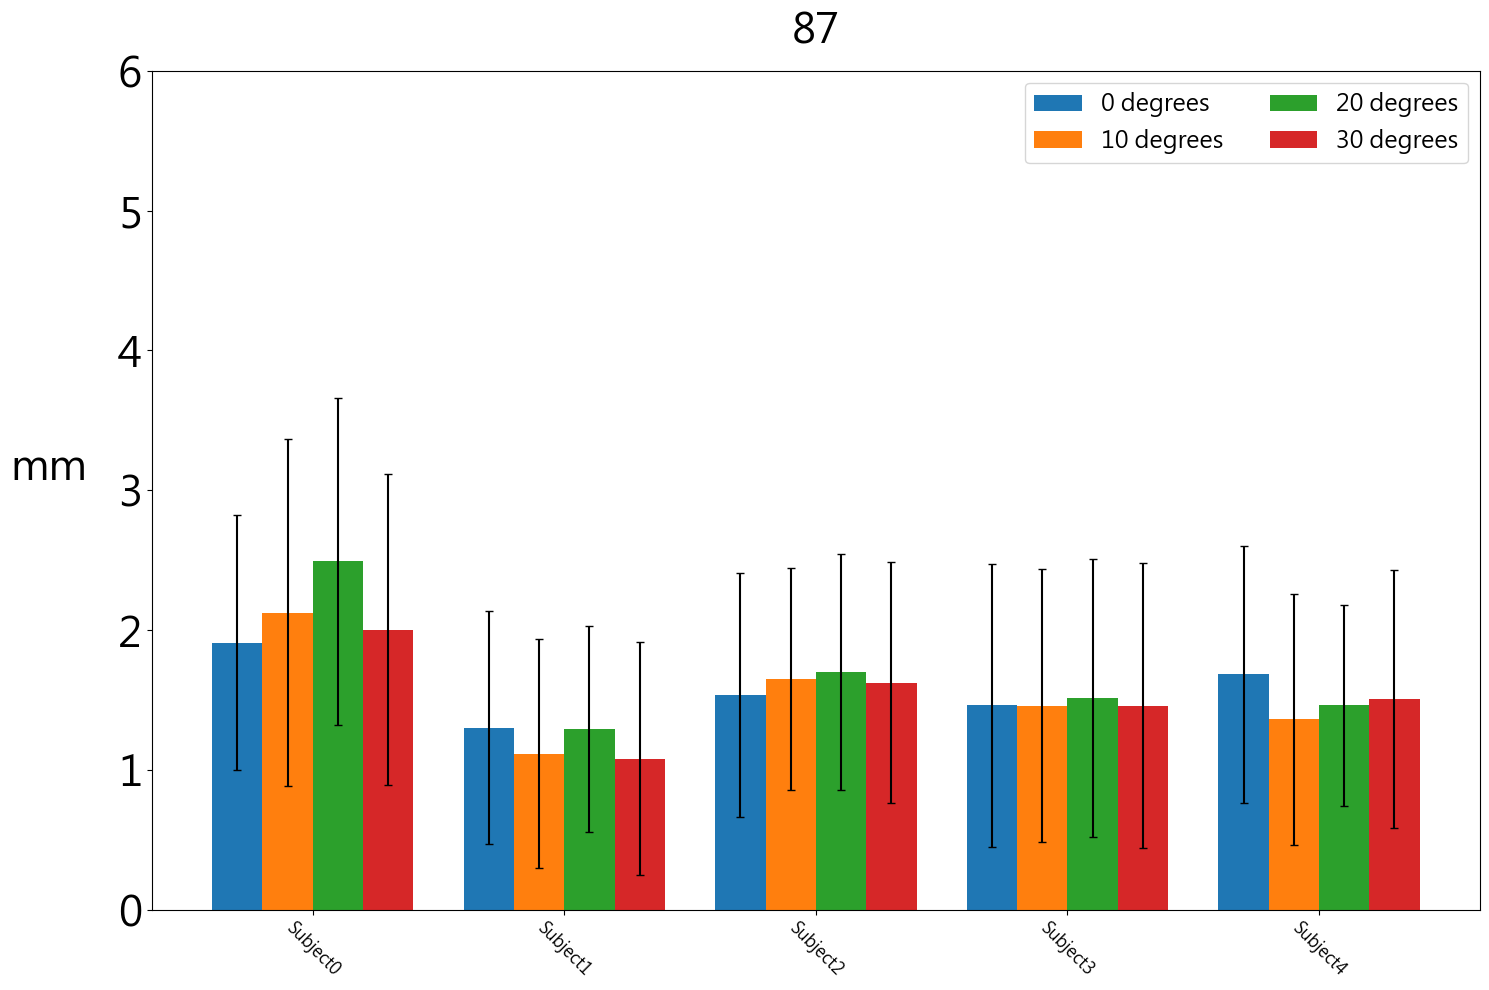

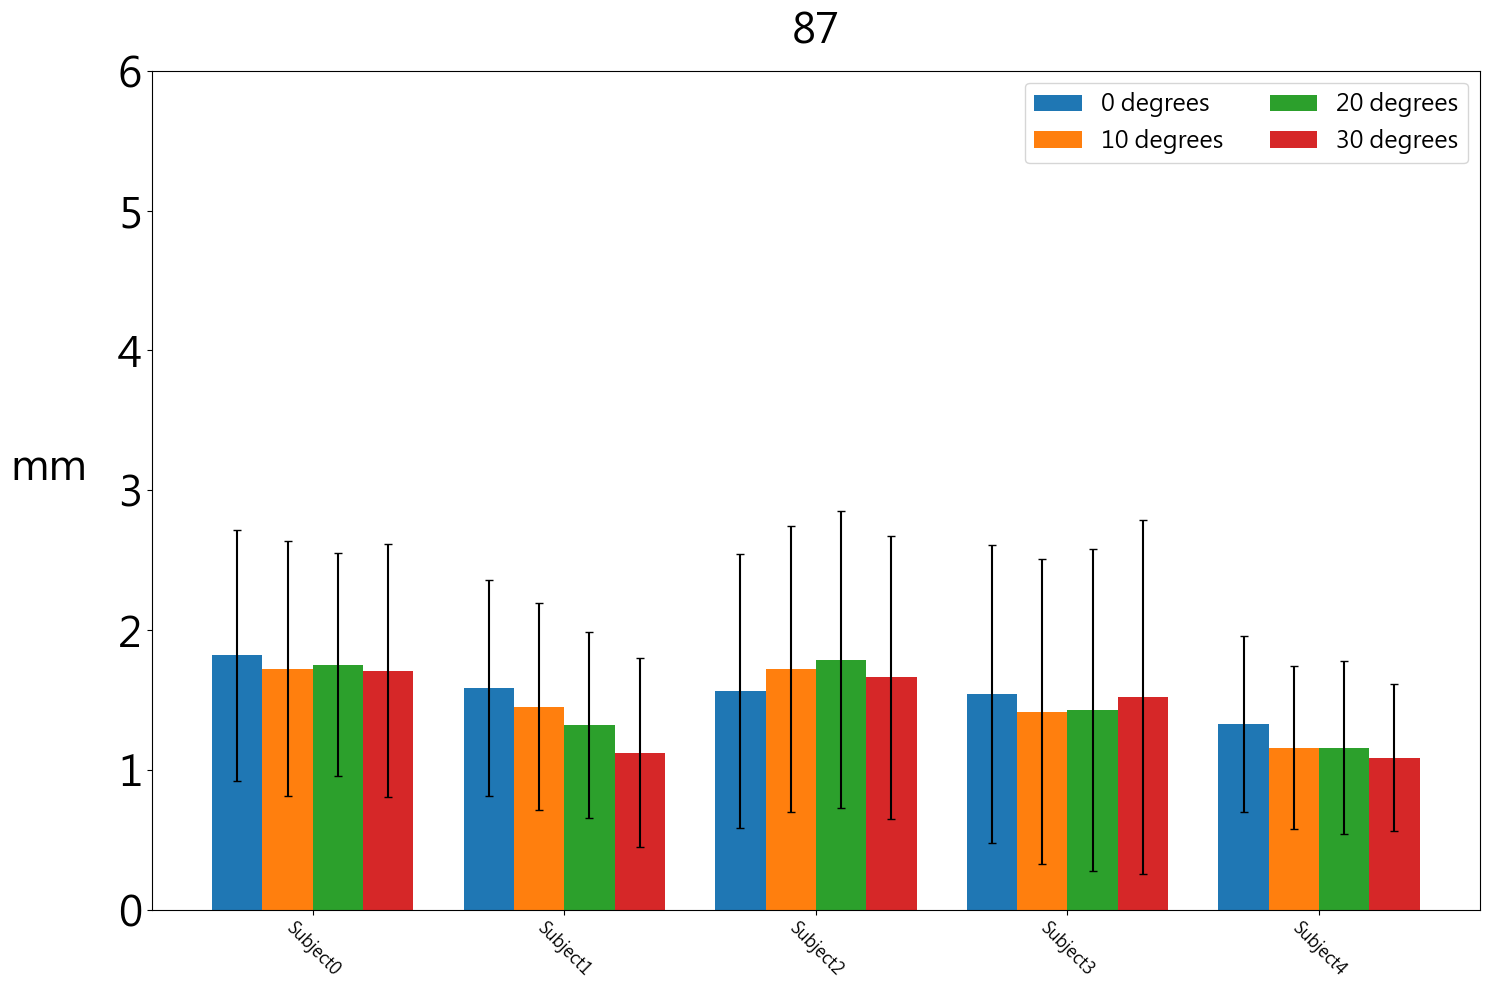

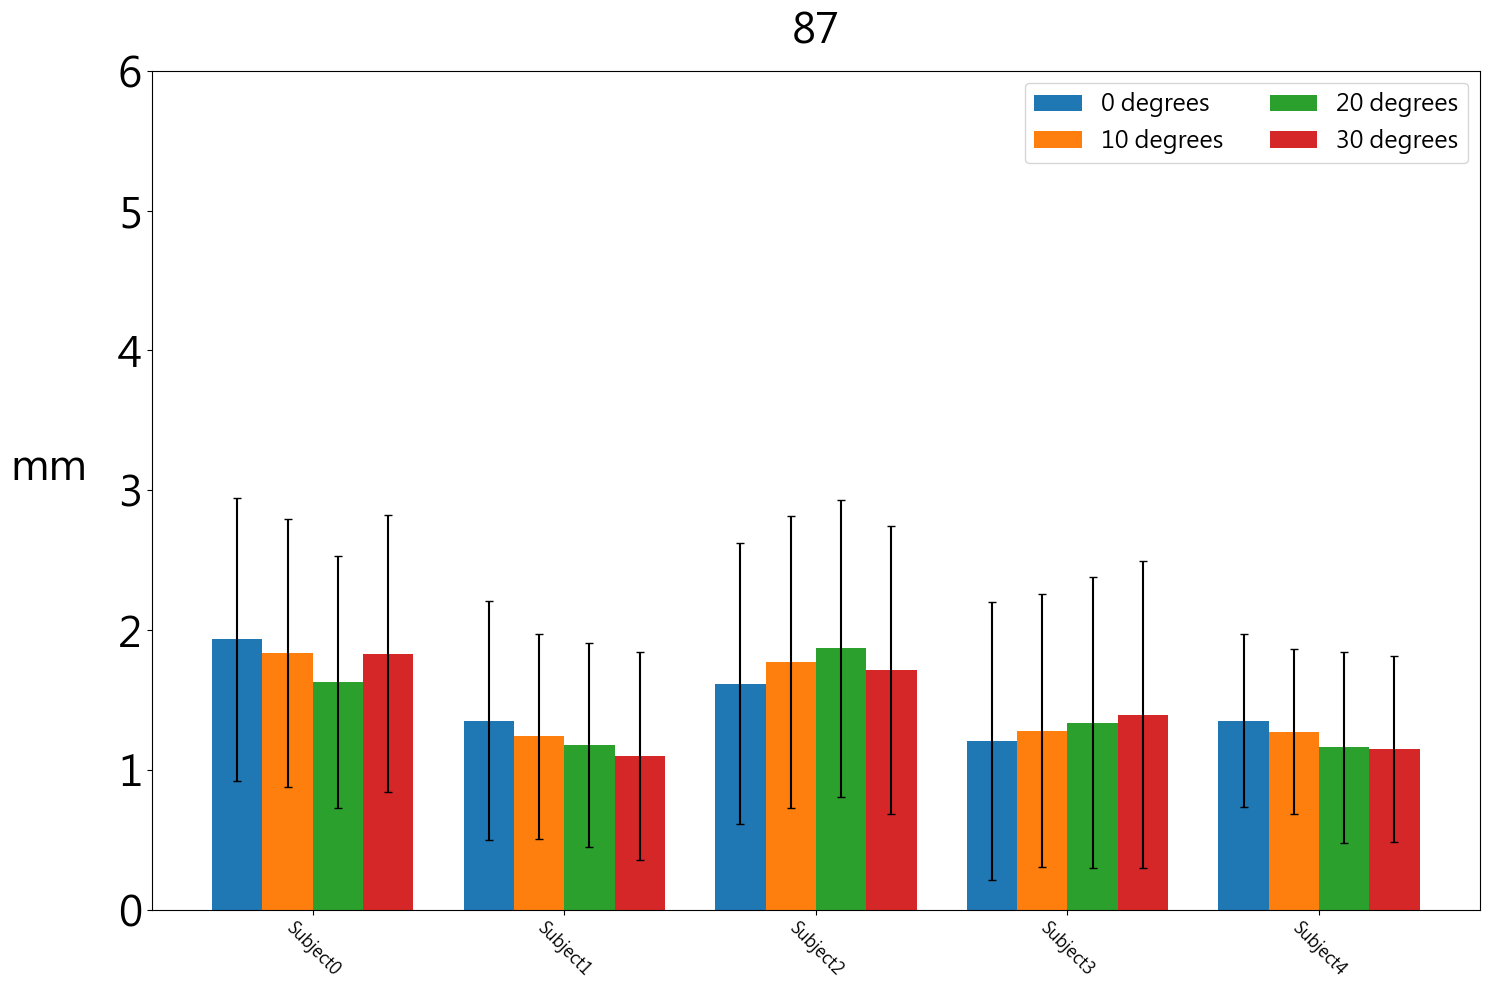

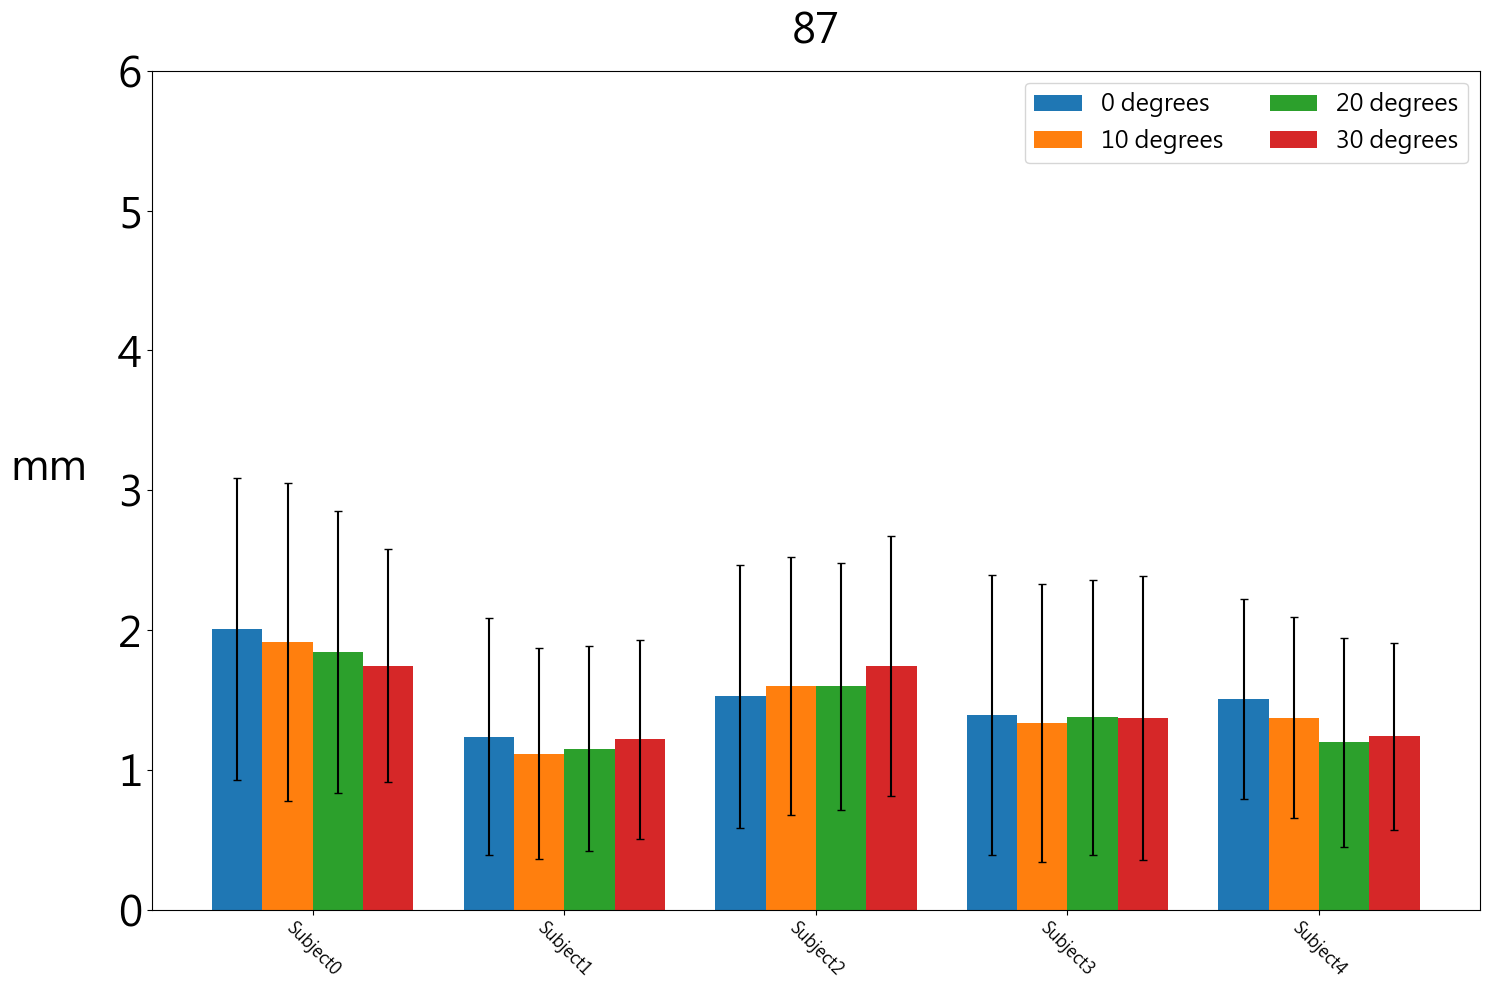

In [5]:
B = localization_error_Draw()
occlu = B.all_error()


In [ ]:
degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
        
wrapped_errors = [B]
plt.figure(figsize=(15,10))
for i in range(0, len(self.wrapped_errors)):    
    means = []
    stds = []
    if i == 1:
        for ear_type in ear_types:
            for deg in self.degrees:
            means.append(np.nanmean(wrapped_errors[i][ear_type], axis = (0,1))*10)
            stds.append(np.nanstd(wrapped_errors[i][ear_type], axis = (0,1))*10)
    else:
        for ear_type in ear_types:
            means.append(np.nanmean(wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
            stds.append(np.nanstd(wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
        
    plt.bar(np.arange(len(ear_types)), means, yerr=stds, align='center', label = ear_type, ecolor='black', capsize=3, width=0.2)

plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

font_path = r'C:\Windows\Fonts\msjhl.ttc'
font = FontProperties(fname=font_path, size=12)
plt.xticks(np.arange(len(self.ear_types)), self.ear_types, fontsize=12, rotation=-45, ha='center')


plt.yticks(fontsize=30)
plt.title(title, fontsize = 30, pad = 20)

#         plt.legend(fontsize=17, ncol = 2)

plt.tight_layout()

#         if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
#             os.makedirs(os.path.join("..", "figure", "occlusion"))
#         plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))

plt.show()


In [49]:
#     def each_acu_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
            
            
#             for deg in self.degrees:
#                 result[ear_type][deg] = []

#                 for i in range(4):
#                     df = pd.DataFrame()
#                     names = os.listdir(os.path.join(self.occluded_result, ear_type))
#                     for name in names:
#                         indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                         error_df = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, indexes[i], "error.csv"))
#                         df = pd.concat([df, error_df])                    



#                     df_np = df.to_numpy()

#                     result[ear_type][deg].append(df_np)
#         print(len(result))
#         print(len(result["free"]))
#         print(result["free"]['15cm_0mm_0deg'][0].shape)
#         return result
    
#     def draw_each_acu_bars(self, title, each_acu_err):
#         for ear_type in self.ear_types:
#             for deg in self.degrees:
                
#                 plt.figure(figsize=(15,10))
#                 for i in range(0, len(each_acu_err[ear_type][deg])): 
#                     means = np.nanmean(each_acu_err[ear_type][deg][i]*10, axis = 0)
#                     stds = np.nanstd(each_acu_err[ear_type][deg][i]*10, axis = 0)
#                     print(means.shape)
# #                     for j in range(0 ,len(each_acu_err[ear_type][deg][i])):
# #                         means = np.nanmean(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
                        
# #                         stds = np.nanstd(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
#                     plt.bar(np.arange(means.shape[0]) + i*0.2, means, yerr=stds, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)


#                 plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#                 plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#                 font_path = r'C:\Windows\Fonts\msjhl.ttc'
#                 font = FontProperties(fname=font_path, size=12)
#                 plt.xticks(np.arange(len(means)) + 0.3, self.acupoints_name[:len(means)], fontsize=12, rotation=-45, ha='center')


#                 plt.yticks(fontsize=30)
#                 plt.title(title, fontsize = 30, pad = 20)

#                 plt.legend(fontsize=17, ncol = 2)

#                 plt.tight_layout()

#     #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#     #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#     #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

#                 plt.show()

#     def each_subject_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
            
            
#             for deg in self.degrees:
#                 result[ear_type][deg] = {}
#                 result[ear_type][deg]["means"] = []
#                 result[ear_type][deg]["stds"] = []
#                 names = os.listdir(os.path.join(self.occluded_result, ear_type))
#                 for i in range(4):
#                     means = []
#                     stds = []
#                     for name in names:
#                         indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                         error_np = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, indexes[i], "error.csv")).to_numpy()
#                         means.append(np.nanmean(error_np*10, axis = (0, 1)))
#                         stds.append(np.nanstd(error_np*10, axis = (0, 1)))                    



                    

#                     result[ear_type][deg]["means"].append(means)
#                     result[ear_type][deg]["stds"].append(stds)

#         return result 
        
        
        
#     def draw_each_subject_bars(self, title, each_subject_err):
#         for ear_type in self.ear_types:
#             for deg in self.degrees:
                
#                 plt.figure(figsize=(15,10))
#                 for i in range(0, len(each_subject_err[ear_type][deg]["means"])): 
# #                     means = np.nanmean(each_subject_err[ear_type][deg][i]*10, axis = (0,1))
# #                     print(means.shape)
# #                     stds = np.nanstd(each_subject_err[ear_type][deg][i]*10, axis = (0,1))
                    
# #                     for j in range(0 ,len(each_acu_err[ear_type][deg][i])):
# #                         means = np.nanmean(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
                        
# #                         stds = np.nanstd(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
#                     plt.bar(np.arange(len(each_subject_err[ear_type][deg]["means"][i])) + i*0.2, each_subject_err[ear_type][deg]["means"][i], yerr=each_subject_err[ear_type][deg]["stds"][i], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)


#                 plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#                 plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#                 font_path = r'C:\Windows\Fonts\msjhl.ttc'
#                 font = FontProperties(fname=font_path, size=12)
#                 plt.xticks(np.arange(len(each_subject_err[ear_type][deg]["means"][0])) + 0.3, ["Subject"+str(x) for x in list(range(0 , len(each_subject_err[ear_type][deg]["means"][0])))], fontsize=12, rotation=-45, ha='center')


#                 plt.yticks(fontsize=30)
#                 plt.title(title, fontsize = 30, pad = 20)

#                 plt.legend(fontsize=17, ncol = 2)

#                 plt.tight_layout()

#     #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#     #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#     #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

#                 plt.show()
#     def total_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
#             df = pd.DataFrame()
#             names = os.listdir(os.path.join(self.occluded_result, ear_type))
#             for name in names:
#                 for deg in self.degrees:
#                     indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                     for index in indexes:
#                         error_df = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, index, "error.csv"))
#                         df = pd.concat([df, error_df])

#             result[ear_type] = df
                    

                    

#         return result 
        
#     def draw_total_bars(self, title, total_err):
#         plt.figure(figsize=(15,10))
        
#         means = []
#         stds = []
#         for ear_type in self.ear_types:
#             means.append(np.nanmean(total_err[ear_type], axis = (0,1))*10)
#             stds.append(np.nanstd(total_err[ear_type], axis = (0,1))*10)
#         print(means)
#         print(stds)

#         plt.bar(np.arange(len(self.ear_types)), means, yerr=stds, align='center', label = ear_type, ecolor='black', capsize=3, width=0.2)

#         plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#         plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#         font_path = r'C:\Windows\Fonts\msjhl.ttc'
#         font = FontProperties(fname=font_path, size=12)
#         plt.xticks(np.arange(len(self.ear_types)), self.ear_types, fontsize=12, rotation=-45, ha='center')


#         plt.yticks(fontsize=30)
#         plt.title(title, fontsize = 30, pad = 20)

# #         plt.legend(fontsize=17, ncol = 2)

#         plt.tight_layout()

# #         if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
# #             os.makedirs(os.path.join("..", "figure", "occlusion"))
# #         plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))

#         plt.show()

(1516, 21)
(1798, 21)
(1195, 21)
(1190, 21)
(1359, 21)
(1959, 21)
(1351, 21)
(1211, 21)
(11579, 21)
(1495, 14)
(1923, 14)
(1535, 14)
(1037, 14)
(1908, 14)
(7898, 14)


ValueError: axes don't match array